# **Credit Risk with Explainable Models and Fairness Evaluation**


*A financial institution seeks to support its credit origination decisions by identifying, in advance, applicants with a high risk of default.
Our mission is to build a technical comparison of models that produce calibrated and explainable probabilities, evaluate their performance, and analyze potential fairness gaps across subgroups.
The outcome should translate into operational recommendations and a clear justification of which model is most suitable and why.*

This notebook analyzes the **German Credit** dataset from the **UCI Machine Learning Repository** to develop a **credit risk classification model**.

## **Dataset Information**
- **Instances**: 1,000 (700 “good” and 300 “bad” credit risks)  
- **Attributes**: 20 (7 numerical, 13 categorical)  
- **Objective**: Classify applicants as **“good” (1)** or **“bad” (2)** credit risk  
- **Cost matrix**: Misclassifying a bad customer as good (cost 5) is more expensive than misclassifying a good customer as bad (cost 1)

## **Attributes**
## Variable Types

### Numerical (3):
- Duration in months
- Credit amount  
- Age in years

### Categorical/Ordinal (18):
- Status of existing checking account
- Credit history
- Purpose
- Savings account/bonds
- Present employment since
- Installment rate (ordinal)
- Personal status and sex
- Other debtors/guarantors
- Present residence since (ordinal)
- Property
- Other installment plans
- Housing
- Number of existing credits (ordinal)
- Job
- Number of people liable
- Telephone
- Foreign worker
- **Target variable** (1=Good, 0=Bad)

## Key Notes
- Variables use P2 scores from Häußler (1979) for credit scoring
- Some "numerical" variables are actually discretized scores
- Target variable: 0=Bad, 1=Good (opposite to original German Credit dataset)

The South German Credit dataset is used because it is a well-documented, corrected, and more interpretable version of the original German Credit dataset.
Its clear coding and detailed sampling notes facilitate explainability and fairness analysis and to evaluate potential biases across subgroups.
Additionally, its balanced and well-structured design makes it ideal for comparing models and justifying which one offers the best performance and transparency.

**1. Exploratory Analysis and Data Quality**

In [97]:
import os, io, json, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from IPython.display import Markdown, display
from pathlib import Path
import pandas as pd
import seaborn as sns
from pathlib import Path




In [98]:
# Función para cargar el dataset South German Credit (.asc)
def read_sgc(path):
    """
    Función para leer el archivo South German Credit (.asc)
    Maneja diferentes separadores y codificaciones
    """
    for sep in [';', ',', r'\s+']:
        try:
            df_ = pd.read_csv(path, sep=sep, encoding='latin1')
            if df_.shape[1] >= 20:
                return df_
        except Exception:
            pass
    return pd.read_csv(path, delim_whitespace=True, engine='python', encoding='latin1')

# Cargar el dataset
df = read_sgc('SouthGermanCredit.asc')

# Definir nombres de columnas
column_names = [
    'laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit', 'rate',
    'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred', 'wohn', 'bishkred',
    'beruf', 'pers', 'telef', 'gastarb', 'kredit'
]

# Asignar nombres si es necesario
if not set(column_names).issubset(df.columns):
    df.columns = column_names

# Renombrar a inglés para mejor interpretación
rename_map = {
    'laufkont': 'checking_account_status', 'laufzeit': 'duration_months', 
    'moral': 'credit_history', 'verw': 'purpose', 'hoehe': 'credit_amount',
    'sparkont': 'savings_account', 'beszeit': 'employment_since', 'rate': 'installment_rate',
    'famges': 'personal_status_sex', 'buerge': 'other_debtors', 'wohnzeit': 'residence_since',
    'verm': 'property', 'alter': 'age', 'weitkred': 'other_installment_plans',
    'wohn': 'housing', 'bishkred': 'existing_credits', 'beruf': 'job',
    'pers': 'people_liable', 'telef': 'telephone', 'gastarb': 'foreign_worker',
    'kredit': 'target'
}

df = df.rename(columns=rename_map)

print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f" Columnas: {list(df.columns[:5])}...")
df.head()


Dataset cargado: 1000 filas, 21 columnas
 Columnas: ['checking_account_status', 'duration_months', 'credit_history', 'purpose', 'credit_amount']...


,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,target
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [99]:
# === Configuración de variables para análisis ===
# Definir directorio de salida
OUTDIR = Path("./eda_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Definir variable objetivo
target_col = "target"

# Definir variables por tipo según el análisis del dataset
numerical_vars = ['duration_months', 'credit_amount', 'age']
ordinal_vars = ['installment_rate', 'residence_since', 'existing_credits', 'people_liable']
categorical_vars = ['checking_account_status', 'credit_history', 'purpose', 'savings_account', 
                   'employment_since', 'personal_status_sex', 'other_debtors', 'property', 
                   'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

# Alias para compatibilidad
num_cols = numerical_vars

print(f"Directorio de salida: {OUTDIR.resolve()}")
print(f"Variable objetivo: {target_col}")
print(f"Variables numéricas ({len(numerical_vars)}): {numerical_vars}")
print(f"Variables ordinales ({len(ordinal_vars)}): {ordinal_vars}")
print(f"Variables categóricas ({len(categorical_vars)}): {categorical_vars}")


Directorio de salida: /Users/janeth/2025Q3 Business Intelligence/P3_Credit_Risk/eda_outputs
Variable objetivo: target
Variables numéricas (3): ['duration_months', 'credit_amount', 'age']
Variables ordinales (4): ['installment_rate', 'residence_since', 'existing_credits', 'people_liable']
Variables categóricas (13): ['checking_account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']


**General Information**

In [100]:
# === Información general
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Forma del dataset: {df.shape}")
print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nTipos de datos:")
print(df.dtypes.value_counts())




=== INFORMACIÓN GENERAL DEL DATASET ===
Forma del dataset: (1000, 21)
Memoria utilizada: 0.16 MB

Tipos de datos:
int64    21
Name: count, dtype: int64


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   checking_account_status  1000 non-null   int64
 1   duration_months          1000 non-null   int64
 2   credit_history           1000 non-null   int64
 3   purpose                  1000 non-null   int64
 4   credit_amount            1000 non-null   int64
 5   savings_account          1000 non-null   int64
 6   employment_since         1000 non-null   int64
 7   installment_rate         1000 non-null   int64
 8   personal_status_sex      1000 non-null   int64
 9   other_debtors            1000 non-null   int64
 10  residence_since          1000 non-null   int64
 11  property                 1000 non-null   int64
 12  age                      1000 non-null   int64
 13  other_installment_plans  1000 non-null   int64
 14  housing                  1000 non-null   int64
 15  exist

In [102]:
missing = df.isna().sum().rename_axis("column").reset_index(name="n_missing")
missing["pct_missing"] = missing["n_missing"] / len(df)
#missing.sort_values("n_missing", ascending=False).to_csv(OUTDIR / "missing_by_col.csv", index=False)
display(missing.sort_values("n_missing", ascending=False).head(10))


,column,n_missing,pct_missing
0,checking_account_status,0,0.0
11,property,0,0.0
19,foreign_worker,0,0.0
18,telephone,0,0.0
17,people_liable,0,0.0
16,job,0,0.0
15,existing_credits,0,0.0
14,housing,0,0.0
13,other_installment_plans,0,0.0
12,age,0,0.0


## Variable Classification

The South German Credit dataset variables are classified based on their underlying data structure and statistical properties. **Numerical variables** (duration, amount, age) represent truly continuous measurements that can take any value within their range. **Categorical variables** contain discrete categories with no inherent ordering (e.g., purpose, housing type), while **ordinal variables** represent discretized scores from an underlying quantitative variable with meaningful ordering (e.g., installment_rate, present_residence, number_credits). The classification follows the P2 scoring system from Häußler (1979), where higher values generally indicate better creditworthiness. This approach allows for direct use in credit scoring models while maintaining the interpretability of categorical relationships. The target variable uses binary encoding (0=Bad, 1=Good) which is the standard convention for credit risk classification, opposite to the original German Credit dataset to maintain consistency with modern machine learning practices.

In [103]:
expected_types = {
    # --- Numerical (3)
    'duration_months': 'numerical',
    'credit_amount': 'numerical',
    'age': 'numerical',

    # --- Ordinal (4)
    'installment_rate': 'ordinal',
    'residence_since': 'ordinal',
    'existing_credits': 'ordinal',
    'people_liable': 'ordinal',  # binaria pero jerárquica (2 niveles)

    # --- Categorical (resto)
    'checking_account_status': 'categorical',
    'credit_history': 'categorical',
    'purpose': 'categorical',
    'savings_account': 'categorical',
    'employment_since': 'categorical',
    'personal_status_sex': 'categorical',
    'other_debtors': 'categorical',
    'property': 'categorical',
    'other_installment_plans': 'categorical',
    'housing': 'categorical',
    'job': 'categorical',
    'telephone': 'categorical',
    'foreign_worker': 'categorical',
    'target': 'categorical'
}


In [104]:
def apply_types(df, type_dict):
    """
    Aplica los tipos de datos según el diccionario definido.
    - 'categorical' -> category
    - 'ordinal' -> category con orden
    - 'numerical' -> float o int
    """
    for col, var_type in type_dict.items():
        if col not in df.columns:
            continue

        if var_type == 'categorical':
            df[col] = df[col].astype('category')

        elif var_type == 'ordinal':
            # Convertimos a categoría ordenada
            df[col] = pd.Categorical(df[col], ordered=True)

        elif var_type == 'numerical':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


**Variable typing**

In [105]:
df = apply_types(df, expected_types)

print("\n=== Tipos de variables aplicados ===")
print(df.dtypes.value_counts())

print("\n=== Ejemplo de cada tipo ===")
print("Numéricas:", [c for c, t in expected_types.items() if t == 'numerical'])
print("Ordinales:", [c for c, t in expected_types.items() if t == 'ordinal'])
print("Categóricas:", [c for c, t in expected_types.items() if t == 'categorical'])



=== Tipos de variables aplicados ===
category    4
int64       3
category    3
category    3
category    2
category    2
category    1
category    1
category    1
category    1
Name: count, dtype: int64

=== Ejemplo de cada tipo ===
Numéricas: ['duration_months', 'credit_amount', 'age']
Ordinales: ['installment_rate', 'residence_since', 'existing_credits', 'people_liable']
Categóricas: ['checking_account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker', 'target']


**Descriptive statistics**

In [106]:
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
desc = df.describe(include='all')
print(desc)

# === Guardar salidas en OUTDIR ===
# 1) Primeras filas
df.head(20).to_csv(OUTDIR / "head_20.csv", index=False, encoding="utf-8")

# 2) Info como .txt
import io
buffer = io.StringIO()
df.info(buf=buffer)
info_text = buffer.getvalue()
with open(OUTDIR / "df_info.txt", "w", encoding="utf-8") as f:
    f.write(info_text)

# 3) Describe como .csv
desc.to_csv(OUTDIR / "df_describe.csv", encoding="utf-8")

# 4) Tipos de datos y memoria
dtype_counts = df.dtypes.value_counts().to_frame("count")
dtype_counts.to_csv(OUTDIR / "dtype_counts.csv", encoding="utf-8")
with open(OUTDIR / "memory_usage_mb.txt", "w", encoding="utf-8") as f:
    f.write(f"{df.memory_usage(deep=True).sum() / 1024**2:.4f} MB")

print(f"\n Salidas EDA guardadas en: {OUTDIR.resolve()}")


=== ESTADÍSTICAS DESCRIPTIVAS ===
        checking_account_status  duration_months  credit_history  purpose  \
count                    1000.0      1000.000000          1000.0   1000.0   
unique                      4.0              NaN             5.0     10.0   
top                         4.0              NaN             2.0      3.0   
freq                      394.0              NaN           530.0    280.0   
mean                        NaN        20.903000             NaN      NaN   
std                         NaN        12.058814             NaN      NaN   
min                         NaN         4.000000             NaN      NaN   
25%                         NaN        12.000000             NaN      NaN   
50%                         NaN        18.000000             NaN      NaN   
75%                         NaN        24.000000             NaN      NaN   
max                         NaN        72.000000             NaN      NaN   

        credit_amount  savings_account  

In [107]:

from scipy import stats

u_tests = []

# --- Boxplots por clase + Mann–Whitney U ---
for col in num_cols:
    # Boxplot por clase
    ax = df.boxplot(column=col, by=target_col, figsize=(5, 3))
    plt.title(f"{col} por {target_col}")
    plt.suptitle("")  # quita supertítulo automático de pandas
    plt.xlabel(f"{target_col} (0=Bad, 1=Good)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(OUTDIR / f"box_{col}_by_{target_col}.png", dpi=160, bbox_inches="tight")
    plt.close()

    # Mann–Whitney U (dos colas) entre clases 0 y 1
    a = df.loc[df[target_col] == 0, col].dropna()
    b = df.loc[df[target_col] == 1, col].dropna()
    if len(a) > 0 and len(b) > 0:
        try:
            stat, p = stats.mannwhitneyu(a, b, alternative="two-sided")
            u_tests.append({"column": col, "U": float(stat), "p_value": float(p),
                            "n_class0": int(len(a)), "n_class1": int(len(b))})
        except Exception as e:
            print(f" Mann–Whitney falló en '{col}': {e}")

# --- Guardar resultados ---
u_df = pd.DataFrame(u_tests).sort_values("p_value", ascending=True)
u_df.to_csv(OUTDIR / "mannwhitney_numeric.csv", index=False, encoding="utf-8")

# Mostrar top 10 (si estás en notebook)
try:
    from IPython.display import display
    display(u_df.head(10))
except Exception:
    print(u_df.head(10))

print(f" Guardado: {OUTDIR / 'mannwhitney_numeric.csv'}")
print(f" Boxplots por variable en: {OUTDIR}")

,column,U,p_value,n_class0,n_class1
0,duration_months,132004.5,7.981666e-11,300,700
2,age,90028.5,3.449070e-04,300,700
1,credit_amount,116520.0,5.917609e-03,300,700


 Guardado: eda_outputs/mannwhitney_numeric.csv
 Boxplots por variable en: eda_outputs


**Class distribution**

We implemented an automated preprocessing routine for the South German Credit dataset.
It detects the file delimiter, assigns column names if missing, sets proper data types (numeric and categorical), translates headers into English, and defines the target variable (credit_risk).
Finally, it categorizes features into numerical, categorical, and ordinal groups, leaving the DataFrame ready for EDA.


=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ===
Bad (0): 300 (30.0%)
Good (1): 700 (70.0%)


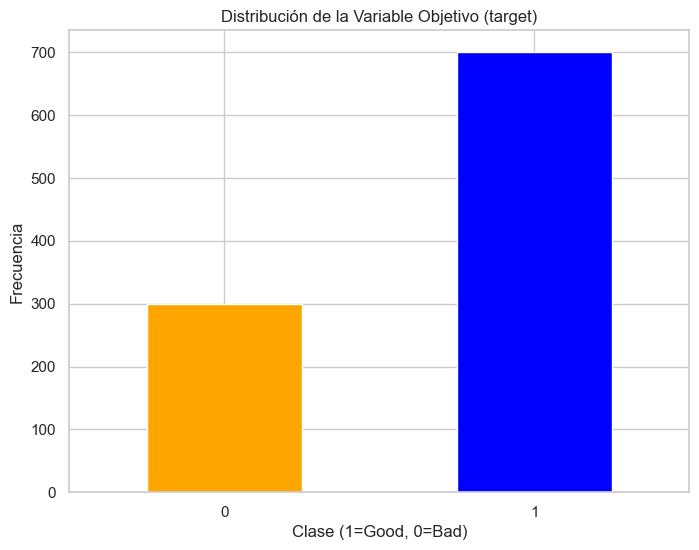

In [108]:

print(f"\n=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ===")
# Verificamos que la columna exista
if 'target' in df.columns:
    target_dist = df['target'].value_counts().sort_index()  # asegura orden 0,1

    # Imprime proporciones
    for val, count in target_dist.items():
        label = "Good (1)" if val == 1 else "Bad (0)"
        print(f"{label}: {count} ({count/len(df)*100:.1f}%)")

    # Visualización
    plt.figure(figsize=(8, 6))
    target_dist.plot(kind='bar', color=['orange', 'blue'])
    plt.title('Distribución de la Variable Objetivo (target)')
    plt.xlabel('Clase (1=Good, 0=Bad)')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=0)
    plt.show()
else:
    print(" La columna 'target' no existe en el DataFrame.")

    print(f"Distribución de clases:")
    print(f"  Bad (0):  {target_dist[0]:,} casos ({target_pct[0]:.1f}%)")
    print(f"  Good (1): {target_dist[1]:,} casos ({target_pct[1]:.1f}%)")
    print(f"  Total:    {len(df):,} casos")

Minority class: The “Non-paying” cases (30%) represent the minority class.
Majority class: The “Paying” cases (70%) dominate the dataset. The 70/30 imbalance is manageable and realistic for credit scoring. It does not require aggressive balancing techniques but does require validation and evaluation strategies that prioritize the correct detection of high-risk (non-paying) cases.

## 3. CLEANING RULES AND IMPACT JUSTIFICATION

In [109]:
print("=== APLICACIÓN DE REGLAS DE LIMPIEZA ===")

# Usa las listas si ya existen; si no, crea una tipificación rápida
if 'numerical_vars' not in globals() or 'categorical_vars' not in globals() or 'ordinal_vars' not in globals():
    cols = [c for c in df.columns if c != target_col]
    numerical_vars, categorical_vars, ordinal_vars = [], [], []
    for c in cols:
        nunq = df[c].nunique(dropna=False)
        if df[c].dtype.kind in "if":
            if nunq <= 5:
                categorical_vars.append(c)
            elif nunq <= 10 and pd.api.types.is_integer_dtype(df[c]):
                ordinal_vars.append(c)
            else:
                numerical_vars.append(c)
        else:
            categorical_vars.append(c)

# --- Copia para limpieza ---
df_clean = df.copy()
cleaning_log = []



=== APLICACIÓN DE REGLAS DE LIMPIEZA ===


In [110]:
# === ANÁLISIS DE OUTLIERS POR TIPO DE VARIABLE ===
print("=== ANÁLISIS DE OUTLIERS POR TIPO DE VARIABLE ===")

# Definir clasificación de variables según el análisis
expected_types = {
    # --- Numerical (3)
    'duration_months': 'numerical',
    'credit_amount': 'numerical',
    'age': 'numerical',

    # --- Ordinal (4)
    'installment_rate': 'ordinal',
    'residence_since': 'ordinal',
    'existing_credits': 'ordinal',
    'people_liable': 'ordinal',  # binaria pero jerárquica (2 niveles)

    # --- Categorical (resto)
    'checking_account_status': 'categorical',
    'credit_history': 'categorical',
    'purpose': 'categorical',
    'savings_account': 'categorical',
    'employment_since': 'categorical',
    'personal_status_sex': 'categorical',
    'other_debtors': 'categorical',
    'property': 'categorical',
    'other_installment_plans': 'categorical',
    'housing': 'categorical',
    'job': 'categorical',
    'telephone': 'categorical',
    'foreign_worker': 'categorical',
    'target': 'categorical'
}

# Separar variables por tipo
numerical_vars = [var for var, var_type in expected_types.items() if var_type == 'numerical']
ordinal_vars = [var for var, var_type in expected_types.items() if var_type == 'ordinal']
categorical_vars = [var for var, var_type in expected_types.items() if var_type == 'categorical']

print(f"Variables numéricas ({len(numerical_vars)}): {numerical_vars}")
print(f"Variables ordinales ({len(ordinal_vars)}): {ordinal_vars}")
print(f"Variables categóricas ({len(categorical_vars)}): {categorical_vars}")

# Función para detectar outliers en variables numéricas
def detect_numerical_outliers(data, column, method='iqr'):
    """
    Detecta outliers en variables numéricas usando diferentes métodos
    """
    series = data[column].dropna()

    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = series[(series < lower_bound) | (series > upper_bound)]

    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(series))
        outliers = series[z_scores > 3]

    elif method == 'modified_zscore':
        median = series.median()
        mad = np.median(np.abs(series - median))
        modified_z_scores = 0.6745 * (series - median) / mad
        outliers = series[np.abs(modified_z_scores) > 3.5]

    return outliers, lower_bound if method == 'iqr' else None, upper_bound if method == 'iqr' else None

# Función para detectar outliers en variables ordinales
def detect_ordinal_outliers(data, column):
    """
    Detecta outliers en variables ordinales basándose en distribución de frecuencias
    """
    value_counts = data[column].value_counts()
    total = len(data[column].dropna())

    # Considerar outliers los valores que representan menos del 1% de los datos
    rare_threshold = 0.01
    rare_values = value_counts[value_counts / total < rare_threshold]

    return rare_values.index.tolist(), rare_threshold

# Función para detectar outliers en variables categóricas
def detect_categorical_outliers(data, column):
    """
    Detecta outliers en variables categóricas (niveles raros)
    """
    value_counts = data[column].value_counts()
    total = len(data[column].dropna())

    # Considerar outliers los niveles que representan menos del 2% de los datos
    rare_threshold = 0.02
    rare_values = value_counts[value_counts / total < rare_threshold]

    return rare_values.index.tolist(), rare_threshold

print(f"\n=== ANÁLISIS DE OUTLIERS ===")


=== ANÁLISIS DE OUTLIERS POR TIPO DE VARIABLE ===
Variables numéricas (3): ['duration_months', 'credit_amount', 'age']
Variables ordinales (4): ['installment_rate', 'residence_since', 'existing_credits', 'people_liable']
Variables categóricas (14): ['checking_account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker', 'target']

=== ANÁLISIS DE OUTLIERS ===


In [111]:
# === 1. OUTLIERS EN VARIABLES NUMÉRICAS ===
print("\n1. OUTLIERS EN VARIABLES NUMÉRICAS")
print("=" * 50)

numerical_outliers_summary = []

for var in numerical_vars:
    print(f"\n--- {var.upper()} ---")

    # Estadísticas básicas
    series = df[var].dropna()
    print(f"Valores únicos: {series.nunique()}")
    print(f"Rango: {series.min()} - {series.max()}")
    print(f"Media: {series.mean():.2f}, Mediana: {series.median():.2f}")
    print(f"Desv. Estándar: {series.std():.2f}")

    # Detectar outliers con diferentes métodos
    outliers_iqr, lower, upper = detect_numerical_outliers(df, var, 'iqr')
    outliers_zscore, _, _ = detect_numerical_outliers(df, var, 'zscore')
    outliers_mod_z, _, _ = detect_numerical_outliers(df, var, 'modified_zscore')

    print(f"Outliers IQR: {len(outliers_iqr)} ({len(outliers_iqr)/len(series)*100:.1f}%)")
    print(f"Outliers Z-Score: {len(outliers_zscore)} ({len(outliers_zscore)/len(series)*100:.1f}%)")
    print(f"Outliers Mod. Z-Score: {len(outliers_mod_z)} ({len(outliers_mod_z)/len(series)*100:.1f}%)")

    if len(outliers_iqr) > 0:
        print(f"Límites IQR: [{lower:.2f}, {upper:.2f}]")
        print(f"Valores outliers: {sorted(outliers_iqr.unique())}")

    # Guardar resumen
    numerical_outliers_summary.append({
        'variable': var,
        'n_outliers_iqr': len(outliers_iqr),
        'pct_outliers_iqr': len(outliers_iqr)/len(series)*100,
        'n_outliers_zscore': len(outliers_zscore),
        'pct_outliers_zscore': len(outliers_zscore)/len(series)*100,
        'n_outliers_mod_z': len(outliers_mod_z),
        'pct_outliers_mod_z': len(outliers_mod_z)/len(series)*100,
        'lower_bound': lower,
        'upper_bound': upper
    })

# Crear DataFrame de resumen
numerical_summary_df = pd.DataFrame(numerical_outliers_summary)
print(f"\n--- RESUMEN VARIABLES NUMÉRICAS ---")
print(numerical_summary_df[['variable', 'n_outliers_iqr', 'pct_outliers_iqr', 'n_outliers_zscore', 'pct_outliers_zscore']])



1. OUTLIERS EN VARIABLES NUMÉRICAS

--- DURATION_MONTHS ---
Valores únicos: 33
Rango: 4 - 72
Media: 20.90, Mediana: 18.00
Desv. Estándar: 12.06
Outliers IQR: 70 (7.0%)
Outliers Z-Score: 14 (1.4%)
Outliers Mod. Z-Score: 16 (1.6%)
Límites IQR: [-6.00, 42.00]
Valores outliers: [np.int64(45), np.int64(47), np.int64(48), np.int64(54), np.int64(60), np.int64(72)]

--- CREDIT_AMOUNT ---
Valores únicos: 923
Rango: 250 - 18424
Media: 3271.25, Mediana: 2319.50
Desv. Estándar: 2822.75
Outliers IQR: 72 (7.2%)
Outliers Z-Score: 25 (2.5%)
Outliers Mod. Z-Score: 70 (7.0%)
Límites IQR: [-2544.62, 7882.38]
Valores outliers: [np.int64(7966), np.int64(7980), np.int64(8065), np.int64(8072), np.int64(8086), np.int64(8133), np.int64(8229), np.int64(8318), np.int64(8335), np.int64(8358), np.int64(8386), np.int64(8471), np.int64(8487), np.int64(8588), np.int64(8613), np.int64(8648), np.int64(8858), np.int64(8947), np.int64(8978), np.int64(9034), np.int64(9055), np.int64(9157), np.int64(9271), np.int64(9277),

In [112]:
# === 2. OUTLIERS EN VARIABLES ORDINALES ===
print("\n\n2. OUTLIERS EN VARIABLES ORDINALES")
print("=" * 50)

ordinal_outliers_summary = []

for var in ordinal_vars:
    print(f"\n--- {var.upper()} ---")

    # Estadísticas básicas
    value_counts = df[var].value_counts().sort_index()
    total = len(df[var].dropna())

    print(f"Valores únicos: {df[var].nunique()}")
    print(f"Distribución de valores:")
    for val, count in value_counts.items():
        pct = count/total*100
        print(f"  {val}: {count} ({pct:.1f}%)")

    # Detectar outliers (niveles raros)
    rare_values, threshold = detect_ordinal_outliers(df, var)

    print(f"Umbral de rareza: {threshold*100:.1f}%")
    print(f"Niveles raros detectados: {rare_values}")

    if rare_values:
        print(f"Frecuencia de niveles raros:")
        for val in rare_values:
            count = value_counts[val]
            pct = count/total*100
            print(f"  {val}: {count} ({pct:.2f}%)")

    # Guardar resumen
    ordinal_outliers_summary.append({
        'variable': var,
        'n_levels': df[var].nunique(),
        'rare_levels': len(rare_values),
        'rare_values': rare_values,
        'threshold': threshold
    })

# Crear DataFrame de resumen
ordinal_summary_df = pd.DataFrame(ordinal_outliers_summary)
print(f"\n--- RESUMEN VARIABLES ORDINALES ---")
print(ordinal_summary_df[['variable', 'n_levels', 'rare_levels', 'rare_values']])




2. OUTLIERS EN VARIABLES ORDINALES

--- INSTALLMENT_RATE ---
Valores únicos: 4
Distribución de valores:
  1: 136 (13.6%)
  2: 231 (23.1%)
  3: 157 (15.7%)
  4: 476 (47.6%)
Umbral de rareza: 1.0%
Niveles raros detectados: []

--- RESIDENCE_SINCE ---
Valores únicos: 4
Distribución de valores:
  1: 130 (13.0%)
  2: 308 (30.8%)
  3: 149 (14.9%)
  4: 413 (41.3%)
Umbral de rareza: 1.0%
Niveles raros detectados: []

--- EXISTING_CREDITS ---
Valores únicos: 4
Distribución de valores:
  1: 633 (63.3%)
  2: 333 (33.3%)
  3: 28 (2.8%)
  4: 6 (0.6%)
Umbral de rareza: 1.0%
Niveles raros detectados: [4]
Frecuencia de niveles raros:
  4: 6 (0.60%)

--- PEOPLE_LIABLE ---
Valores únicos: 2
Distribución de valores:
  1: 155 (15.5%)
  2: 845 (84.5%)
Umbral de rareza: 1.0%
Niveles raros detectados: []

--- RESUMEN VARIABLES ORDINALES ---
           variable  n_levels  rare_levels rare_values
0  installment_rate         4            0          []
1   residence_since         4            0          []
2  

In [113]:
# === 3. OUTLIERS EN VARIABLES CATEGÓRICAS ===
print("\n\n3. OUTLIERS EN VARIABLES CATEGÓRICAS")
print("=" * 50)

categorical_outliers_summary = []

for var in categorical_vars:
    print(f"\n--- {var.upper()} ---")

    # Estadísticas básicas
    value_counts = df[var].value_counts().sort_index()
    total = len(df[var].dropna())

    print(f"Valores únicos: {df[var].nunique()}")
    print(f"Distribución de valores:")
    for val, count in value_counts.head(10).items():  # Mostrar solo los primeros 10
        pct = count/total*100
        print(f"  {val}: {count} ({pct:.1f}%)")

    if len(value_counts) > 10:
        print(f"  ... y {len(value_counts)-10} más")

    # Detectar outliers (niveles raros)
    rare_values, threshold = detect_categorical_outliers(df, var)

    print(f"Umbral de rareza: {threshold*100:.1f}%")
    print(f"Niveles raros detectados: {rare_values}")

    if rare_values:
        print(f"Frecuencia de niveles raros:")
        for val in rare_values:
            count = value_counts[val]
            pct = count/total*100
            print(f"  {val}: {count} ({pct:.2f}%)")

    # Guardar resumen
    categorical_outliers_summary.append({
        'variable': var,
        'n_levels': df[var].nunique(),
        'rare_levels': len(rare_values),
        'rare_values': rare_values,
        'threshold': threshold
    })

# Crear DataFrame de resumen
categorical_summary_df = pd.DataFrame(categorical_outliers_summary)
print(f"\n--- RESUMEN VARIABLES CATEGÓRICAS ---")
print(categorical_summary_df[['variable', 'n_levels', 'rare_levels', 'rare_values']])




3. OUTLIERS EN VARIABLES CATEGÓRICAS

--- CHECKING_ACCOUNT_STATUS ---
Valores únicos: 4
Distribución de valores:
  1: 274 (27.4%)
  2: 269 (26.9%)
  3: 63 (6.3%)
  4: 394 (39.4%)
Umbral de rareza: 2.0%
Niveles raros detectados: []

--- CREDIT_HISTORY ---
Valores únicos: 5
Distribución de valores:
  0: 40 (4.0%)
  1: 49 (4.9%)
  2: 530 (53.0%)
  3: 88 (8.8%)
  4: 293 (29.3%)
Umbral de rareza: 2.0%
Niveles raros detectados: []

--- PURPOSE ---
Valores únicos: 10
Distribución de valores:
  0: 234 (23.4%)
  1: 103 (10.3%)
  2: 181 (18.1%)
  3: 280 (28.0%)
  4: 12 (1.2%)
  5: 22 (2.2%)
  6: 50 (5.0%)
  8: 9 (0.9%)
  9: 97 (9.7%)
  10: 12 (1.2%)
Umbral de rareza: 2.0%
Niveles raros detectados: [4, 10, 8]
Frecuencia de niveles raros:
  4: 12 (1.20%)
  10: 12 (1.20%)
  8: 9 (0.90%)

--- SAVINGS_ACCOUNT ---
Valores únicos: 5
Distribución de valores:
  1: 603 (60.3%)
  2: 103 (10.3%)
  3: 63 (6.3%)
  4: 48 (4.8%)
  5: 183 (18.3%)
Umbral de rareza: 2.0%
Niveles raros detectados: []

--- EMPLOYM



4. VISUALIZACIONES DE OUTLIERS


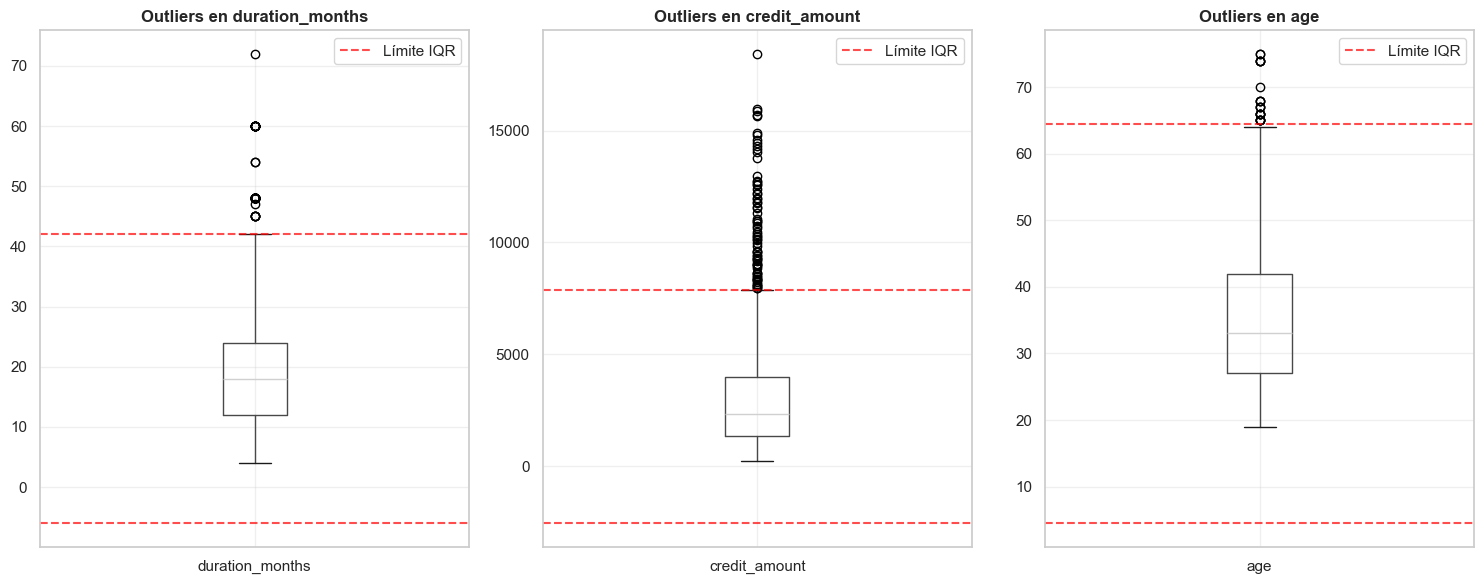

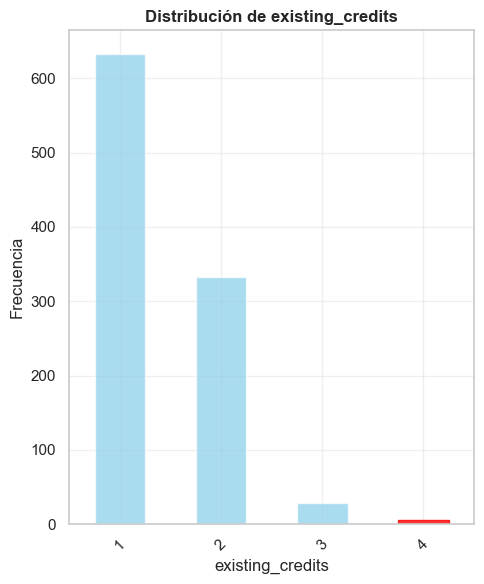

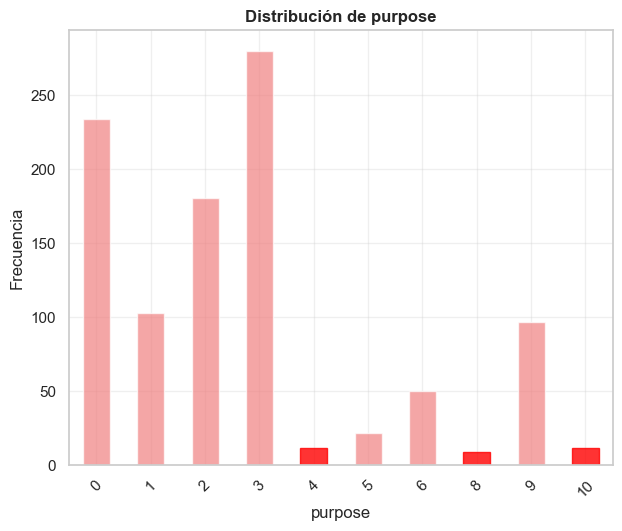

 Visualizaciones de outliers generadas


In [114]:
# === 4. VISUALIZACIONES DE OUTLIERS ===
print("\n\n4. VISUALIZACIONES DE OUTLIERS")
print("=" * 50)

# Crear visualizaciones para variables numéricas
if numerical_vars:
    n_numerical = len(numerical_vars)
    fig, axes = plt.subplots(1, n_numerical, figsize=(5*n_numerical, 6))
    if n_numerical == 1:
        axes = [axes]

    for i, var in enumerate(numerical_vars):
        # Boxplot
        df.boxplot(column=var, ax=axes[i])
        axes[i].set_title(f'Outliers en {var}', fontweight='bold')
        axes[i].grid(True, alpha=0.3)

        # Agregar límites IQR si existen
        if var in numerical_summary_df['variable'].values:
            row = numerical_summary_df[numerical_summary_df['variable'] == var].iloc[0]
            if pd.notna(row['lower_bound']) and pd.notna(row['upper_bound']):
                axes[i].axhline(y=row['lower_bound'], color='red', linestyle='--', alpha=0.7, label='Límite IQR')
                axes[i].axhline(y=row['upper_bound'], color='red', linestyle='--', alpha=0.7)
                axes[i].legend()

    plt.tight_layout()
    plt.show()

# Crear visualizaciones para variables ordinales con niveles raros
ordinal_with_outliers = ordinal_summary_df[ordinal_summary_df['rare_levels'] > 0]
if len(ordinal_with_outliers) > 0:
    n_ordinal = len(ordinal_with_outliers)
    fig, axes = plt.subplots(1, n_ordinal, figsize=(5*n_ordinal, 6))
    if n_ordinal == 1:
        axes = [axes]

    for i, (_, row) in enumerate(ordinal_with_outliers.iterrows()):
        var = row['variable']
        value_counts = df[var].value_counts().sort_index()

        # Gráfico de barras
        value_counts.plot(kind='bar', ax=axes[i], color='skyblue', alpha=0.7)
        axes[i].set_title(f'Distribución de {var}', fontweight='bold')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frecuencia')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

        # Resaltar niveles raros
        for val in row['rare_values']:
            if val in value_counts.index:
                idx = value_counts.index.get_loc(val)
                axes[i].get_children()[idx].set_color('red')
                axes[i].get_children()[idx].set_alpha(0.8)

    plt.tight_layout()
    plt.show()

# Crear visualizaciones para variables categóricas con niveles raros
categorical_with_outliers = categorical_summary_df[categorical_summary_df['rare_levels'] > 0]
if len(categorical_with_outliers) > 0:
    n_categorical = min(len(categorical_with_outliers), 4)  # Máximo 4 gráficos
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, (_, row) in enumerate(categorical_with_outliers.head(4).iterrows()):
        var = row['variable']
        value_counts = df[var].value_counts().sort_index()

        # Gráfico de barras
        value_counts.plot(kind='bar', ax=axes[i], color='lightcoral', alpha=0.7)
        axes[i].set_title(f'Distribución de {var}', fontweight='bold')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frecuencia')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

        # Resaltar niveles raros
        for val in row['rare_values']:
            if val in value_counts.index:
                idx = value_counts.index.get_loc(val)
                axes[i].get_children()[idx].set_color('red')
                axes[i].get_children()[idx].set_alpha(0.8)

    # Ocultar subplots vacíos
    for i in range(n_categorical, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

print(" Visualizaciones de outliers generadas")


In [115]:
# === 5. RESUMEN EJECUTIVO DE OUTLIERS ===
print("\n\n5. RESUMEN EJECUTIVO DE OUTLIERS")
print("=" * 50)

# Resumen general
total_numerical_outliers = numerical_summary_df['n_outliers_iqr'].sum()
total_ordinal_outliers = ordinal_summary_df['rare_levels'].sum()
total_categorical_outliers = categorical_summary_df['rare_levels'].sum()

print(f"RESUMEN GENERAL:")
print(f"- Variables numéricas con outliers: {len(numerical_summary_df[numerical_summary_df['n_outliers_iqr'] > 0])}/{len(numerical_vars)}")
print(f"- Variables ordinales con niveles raros: {len(ordinal_summary_df[ordinal_summary_df['rare_levels'] > 0])}/{len(ordinal_vars)}")
print(f"- Variables categóricas con niveles raros: {len(categorical_summary_df[categorical_summary_df['rare_levels'] > 0])}/{len(categorical_vars)}")

print(f"\nTOTAL DE OUTLIERS DETECTADOS:")
print(f"- Outliers numéricos (IQR): {total_numerical_outliers}")
print(f"- Niveles raros ordinales: {total_ordinal_outliers}")
print(f"- Niveles raros categóricos: {total_categorical_outliers}")

# Recomendaciones por tipo de variable
print(f"\nRECOMENDACIONES POR TIPO DE VARIABLE:")

print(f"\n VARIABLES NUMÉRICAS:")
for _, row in numerical_summary_df.iterrows():
    if row['n_outliers_iqr'] > 0:
        pct = row['pct_outliers_iqr']
        if pct > 10:
            recommendation = "  CRÍTICO: Considerar eliminación o transformación"
        elif pct > 5:
            recommendation = "  ALTO: Considerar winsorización"
        else:
            recommendation = " BAJO: Monitorear en modelado"
        print(f"  {row['variable']}: {row['n_outliers_iqr']} outliers ({pct:.1f}%) - {recommendation}")

print(f"\n VARIABLES ORDINALES:")
for _, row in ordinal_summary_df.iterrows():
    if row['rare_levels'] > 0:
        print(f"  {row['variable']}: {row['rare_levels']} niveles raros - Considerar agrupación")

print(f"\n VARIABLES CATEGÓRICAS:")
for _, row in categorical_summary_df.iterrows():
    if row['rare_levels'] > 0:
        print(f"  {row['variable']}: {row['rare_levels']} niveles raros - Considerar agrupación en 'Other'")

# Guardar resultados
outliers_results = {
    'numerical_summary': numerical_summary_df,
    'ordinal_summary': ordinal_summary_df,
    'categorical_summary': categorical_summary_df,
    'expected_types': expected_types
}

print(f"\n Análisis de outliers completado")
print(f" Resultados guardados en 'outliers_results'")
print(f" Listo para implementar estrategias de limpieza específicas por tipo de variable")




5. RESUMEN EJECUTIVO DE OUTLIERS
RESUMEN GENERAL:
- Variables numéricas con outliers: 3/3
- Variables ordinales con niveles raros: 1/4
- Variables categóricas con niveles raros: 1/14

TOTAL DE OUTLIERS DETECTADOS:
- Outliers numéricos (IQR): 165
- Niveles raros ordinales: 1
- Niveles raros categóricos: 3

RECOMENDACIONES POR TIPO DE VARIABLE:

 VARIABLES NUMÉRICAS:
  duration_months: 70 outliers (7.0%) -   ALTO: Considerar winsorización
  credit_amount: 72 outliers (7.2%) -   ALTO: Considerar winsorización
  age: 23 outliers (2.3%) -  BAJO: Monitorear en modelado

 VARIABLES ORDINALES:
  existing_credits: 1 niveles raros - Considerar agrupación

 VARIABLES CATEGÓRICAS:
  purpose: 3 niveles raros - Considerar agrupación en 'Other'

 Análisis de outliers completado
 Resultados guardados en 'outliers_results'
 Listo para implementar estrategias de limpieza específicas por tipo de variable


**Outlier Treatment by Variable Type**

Purpose: This section implements specific treatment strategies for each type of detected outlier, applying appropriate methods according to the nature of the variable (numerical, ordinal, categorical). It is crucial for improving data quality without losing valuable information and for preparing the dataset for modeling

In [116]:
# === TRATAMIENTO DE OUTLIERS POR TIPO DE VARIABLE ===
print("=== TRATAMIENTO DE OUTLIERS POR TIPO DE VARIABLE ===")

# Crear copia del dataset para tratamiento
df_cleaned = df.copy()
cleaning_log = []

print(f"Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")

# === 1. TRATAMIENTO DE OUTLIERS NUMÉRICOS ===
print(f"\n1. TRATAMIENTO DE OUTLIERS NUMÉRICOS")
print("=" * 50)

def treat_numerical_outliers(data, column, method='winsorize', threshold=0.05):
    """
    Trata outliers en variables numéricas usando diferentes métodos
    """
    series = data[column].copy()
    original_count = len(series)

    # Detectar outliers
    outliers_iqr, lower, upper = detect_numerical_outliers(data, column, 'iqr')
    outlier_pct = len(outliers_iqr) / len(series)

    if outlier_pct < threshold:
        return series, 0, f"No se requiere tratamiento (outliers < {threshold*100:.1f}%)"

    if method == 'winsorize':
        # Winsorización: reemplazar outliers con percentiles 1% y 99%
        p1, p99 = series.quantile([0.01, 0.99])
        series = series.clip(lower=p1, upper=p99)
        treated_count = len(outliers_iqr)
        return series, treated_count, f"Winsorización 1%-99% ({treated_count} valores)"

    elif method == 'iqr_clip':
        # Clipping con límites IQR
        series = series.clip(lower=lower, upper=upper)
        treated_count = len(outliers_iqr)
        return series, treated_count, f"Clipping IQR ({treated_count} valores)"

    elif method == 'remove':
        # Eliminar outliers (no recomendado para este dataset)
        mask = ~((series < lower) | (series > upper))
        series = series[mask]
        treated_count = original_count - len(series)
        return series, treated_count, f"Eliminación ({treated_count} filas)"

# Aplicar tratamiento a variables numéricas
for var in numerical_vars:
    print(f"\n--- {var.upper()} ---")

    # Verificar si hay outliers significativos
    outliers_iqr, lower, upper = detect_numerical_outliers(df, var, 'iqr')
    outlier_pct = len(outliers_iqr) / len(df[var])

    if outlier_pct >= 0.05:  # Solo tratar si hay más del 5% de outliers
        print(f"Outliers detectados: {len(outliers_iqr)} ({outlier_pct*100:.1f}%)")

        # Aplicar winsorización
        treated_series, treated_count, method_desc = treat_numerical_outliers(df, var, 'winsorize')
        df_cleaned[var] = treated_series

        print(f"Tratamiento aplicado: {method_desc}")

        # Registrar en log
        cleaning_log.append({
            'variable': var,
            'tipo': 'numerical',
            'metodo': 'winsorize',
            'valores_tratados': treated_count,
            'descripcion': method_desc
        })
    else:
        print(f"Outliers: {len(outliers_iqr)} ({outlier_pct*100:.1f}%) - No se requiere tratamiento")

print(f"\n Tratamiento de outliers numéricos completado")


=== TRATAMIENTO DE OUTLIERS POR TIPO DE VARIABLE ===
Dataset original: 1000 filas, 21 columnas

1. TRATAMIENTO DE OUTLIERS NUMÉRICOS

--- DURATION_MONTHS ---
Outliers detectados: 70 (7.0%)
Tratamiento aplicado: Winsorización 1%-99% (70 valores)

--- CREDIT_AMOUNT ---
Outliers detectados: 72 (7.2%)
Tratamiento aplicado: Winsorización 1%-99% (72 valores)

--- AGE ---
Outliers: 23 (2.3%) - No se requiere tratamiento

 Tratamiento de outliers numéricos completado


In [117]:
# Función corregida para tratar outliers ordinales


def treat_ordinal_outliers(data, column, rare_threshold=0.01, replacement='median'):
    """
    Trata niveles raros en variables ordinales
    Maneja correctamente variables categóricas y numéricas
    """
    series = data[column].copy()
    value_counts = series.value_counts()
    total = len(series.dropna())

    # Identificar niveles raros
    rare_values = value_counts[value_counts / total < rare_threshold].index.tolist()

    if not rare_values:
        return series, 0, "No se requiere tratamiento"

    # Verificar si la variable es categórica
    is_categorical = pd.api.types.is_categorical_dtype(series)
    
    if replacement == 'median':
        if is_categorical:
            # Para variables categóricas, usar la moda en lugar de la mediana
            mode_val = series.mode()[0] if not series.mode().empty else series.value_counts().index[0]
            series = series.replace(rare_values, mode_val)
            method_desc = f"Reemplazo con moda ({mode_val}) - variable categórica"
        else:
            # Para variables numéricas, usar la mediana
            median_val = series.median()
            series = series.replace(rare_values, median_val)
            method_desc = f"Reemplazo con mediana ({median_val})"

    elif replacement == 'mode':
        # Reemplazar con la moda (valor más frecuente)
        mode_val = series.mode()[0] if not series.mode().empty else series.value_counts().index[0]
        series = series.replace(rare_values, mode_val)
        method_desc = f"Reemplazo con moda ({mode_val})"

    elif replacement == 'group':
        # Agrupar en categoría especial
        series = series.replace(rare_values, 'rare_ordinal')
        method_desc = "Agrupación en 'rare_ordinal'"

    treated_count = sum(value_counts[val] for val in rare_values)
    return series, treated_count, f"{method_desc} ({treated_count} valores)"





In [118]:
# === 3. TRATAMIENTO DE NIVELES RAROS EN VARIABLES CATEGÓRICAS ===
print(f"\n3. TRATAMIENTO DE NIVELES RAROS EN VARIABLES CATEGÓRICAS")
print("=" * 50)

def treat_categorical_outliers(data, column, rare_threshold=0.02, replacement='group'):
    """
    Trata niveles raros en variables categóricas
    """
    series = data[column].copy()
    value_counts = series.value_counts()
    total = len(series.dropna())

    # Identificar niveles raros
    rare_values = value_counts[value_counts / total < rare_threshold].index.tolist()

    if not rare_values:
        return series, 0, "No se requiere tratamiento"

    if replacement == 'group':
        # Agrupar en categoría 'Other'
        series = series.replace(rare_values, 'Other')
        method_desc = "Agrupación en 'Other'"

    elif replacement == 'mode':
        # Reemplazar con la moda
        mode_val = series.mode()[0] if not series.mode().empty else series.value_counts().index[0]
        series = series.replace(rare_values, mode_val)
        method_desc = f"Reemplazo con moda ({mode_val})"

    elif replacement == 'remove':
        # Eliminar niveles raros (convertir a NaN)
        series = series.replace(rare_values, np.nan)
        method_desc = "Conversión a NaN"

    treated_count = sum(value_counts[val] for val in rare_values)
    return series, treated_count, f"{method_desc} ({treated_count} valores)"

# Aplicar tratamiento a variables categóricas (excluyendo target)
categorical_vars_no_target = [var for var in categorical_vars if var != 'target']

for var in categorical_vars_no_target:
    print(f"\n--- {var.upper()} ---")

    # Verificar si hay niveles raros
    rare_values, threshold = detect_categorical_outliers(df, var)

    if rare_values:
        print(f"Niveles raros detectados: {rare_values}")

        # Aplicar tratamiento (agrupar en 'Other')
        treated_series, treated_count, method_desc = treat_categorical_outliers(df, var, threshold, 'group')
        df_cleaned[var] = treated_series

        print(f"Tratamiento aplicado: {method_desc}")

        # Registrar en log
        cleaning_log.append({
            'variable': var,
            'tipo': 'categorical',
            'metodo': 'group_other',
            'valores_tratados': treated_count,
            'descripcion': method_desc
        })
    else:
        print(f"No se detectaron niveles raros")

print(f"\n Tratamiento de niveles raros categóricos completado")



3. TRATAMIENTO DE NIVELES RAROS EN VARIABLES CATEGÓRICAS

--- CHECKING_ACCOUNT_STATUS ---
No se detectaron niveles raros

--- CREDIT_HISTORY ---
No se detectaron niveles raros

--- PURPOSE ---
Niveles raros detectados: [4, 10, 8]
Tratamiento aplicado: Agrupación en 'Other' (33 valores)

--- SAVINGS_ACCOUNT ---
No se detectaron niveles raros

--- EMPLOYMENT_SINCE ---
No se detectaron niveles raros

--- PERSONAL_STATUS_SEX ---
No se detectaron niveles raros

--- OTHER_DEBTORS ---
No se detectaron niveles raros

--- PROPERTY ---
No se detectaron niveles raros

--- OTHER_INSTALLMENT_PLANS ---
No se detectaron niveles raros

--- HOUSING ---
No se detectaron niveles raros

--- JOB ---
No se detectaron niveles raros

--- TELEPHONE ---
No se detectaron niveles raros

--- FOREIGN_WORKER ---
No se detectaron niveles raros

 Tratamiento de niveles raros categóricos completado


/var/folders/xr/6vq7_vj928v9_ssgxbv0bvr00000gp/T/ipykernel_95120/1247991034.py:21: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  series = series.replace(rare_values, 'Other')


In [119]:
# === 4. VALIDACIÓN Y COMPARACIÓN DE RESULTADOS ===
print(f"\n4. VALIDACIÓN Y COMPARACIÓN DE RESULTADOS")
print("=" * 50)

# Verificar que las variables estén definidas
if 'numerical_vars' not in locals():
    numerical_vars = [var for var, var_type in expected_types.items() if var_type == 'numerical']
if 'ordinal_vars' not in locals():
    ordinal_vars = [var for var, var_type in expected_types.items() if var_type == 'ordinal']
if 'categorical_vars' not in locals():
    categorical_vars = [var for var, var_type in expected_types.items() if var_type == 'categorical']

categorical_vars_no_target = [var for var in categorical_vars if var != 'target']

# Comparar estadísticas antes y después del tratamiento
print("COMPARACIÓN ANTES vs DESPUÉS DEL TRATAMIENTO:")
print("-" * 60)

comparison_results = []

for var in numerical_vars + ordinal_vars + categorical_vars_no_target:
    try:
        # Verificar que la variable existe en ambos datasets
        if var not in df.columns or var not in df_cleaned.columns:
            print(f"  Variable {var} no encontrada en uno de los datasets")
            continue

        # Obtener estadísticas según el tipo de variable
        if df[var].dtype in ['int64', 'float64']:
            # Variables numéricas/ordinales
            original_stats = df[var].describe()
            cleaned_stats = df_cleaned[var].describe()

            comparison_results.append({
                'variable': var,
                'tipo': expected_types.get(var, 'unknown'),
                'original_mean': original_stats['mean'],
                'cleaned_mean': cleaned_stats['mean'],
                'original_std': original_stats['std'],
                'cleaned_std': cleaned_stats['std'],
                'original_min': original_stats['min'],
                'cleaned_min': cleaned_stats['min'],
                'original_max': original_stats['max'],
                'cleaned_max': cleaned_stats['max']
            })
        else:
            # Variables categóricas
            original_n_levels = df[var].nunique()
            cleaned_n_levels = df_cleaned[var].nunique()
            comparison_results.append({
                'variable': var,
                'tipo': expected_types.get(var, 'unknown'),
                'original_n_levels': original_n_levels,
                'cleaned_n_levels': cleaned_n_levels,
                'levels_reduced': original_n_levels - cleaned_n_levels
            })
    except Exception as e:
        print(f"  Error procesando variable {var}: {str(e)}")
        continue

# Mostrar resumen de cambios
print("\nRESUMEN DE CAMBIOS:")
print("-" * 30)

for result in comparison_results:
    try:
        if result['tipo'] in ['numerical', 'ordinal']:
            if result['original_mean'] != 0:  # Evitar división por cero
                mean_change = ((result['cleaned_mean'] - result['original_mean']) / result['original_mean']) * 100
            else:
                mean_change = 0

            if result['original_std'] != 0:  # Evitar división por cero
                std_change = ((result['cleaned_std'] - result['original_std']) / result['original_std']) * 100
            else:
                std_change = 0

            print(f"{result['variable']}: Media {mean_change:+.1f}%, Std {std_change:+.1f}%")
        else:
            if 'levels_reduced' in result and result['levels_reduced'] > 0:
                print(f"{result['variable']}: {result['levels_reduced']} niveles reducidos ({result['original_n_levels']} → {result['cleaned_n_levels']})")
            elif 'levels_reduced' in result and result['levels_reduced'] == 0:
                print(f"{result['variable']}: Sin cambios en niveles categóricos")
    except Exception as e:
        print(f"  Error mostrando resultado para {result['variable']}: {str(e)}")

# Mostrar log de limpieza
print(f"\nLOG DE LIMPIEZA APLICADA:")
print("-" * 40)

if 'cleaning_log' in locals() and len(cleaning_log) > 0:
    try:
        cleaning_log_df = pd.DataFrame(cleaning_log)
        print(cleaning_log_df[['variable', 'tipo', 'metodo', 'valores_tratados', 'descripcion']])
    except Exception as e:
        print(f"Error mostrando log de limpieza: {str(e)}")
        print("Log de limpieza:")
        for log in cleaning_log:
            print(f"  {log}")
else:
    print("No se aplicaron tratamientos de outliers")

# Guardar dataset limpio
try:
    df_cleaned.to_csv('credit_data_outliers_treated.csv', index=False)
    print(f"\n Dataset con outliers tratados guardado como 'credit_data_outliers_treated.csv'")
except Exception as e:
    print(f"  Error guardando dataset: {str(e)}")

# Estadísticas finales
print(f"\nESTADÍSTICAS FINALES:")
print(f"- Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"- Dataset limpio: {df_cleaned.shape[0]} filas, {df_cleaned.shape[1]} columnas")

if 'cleaning_log' in locals():
    print(f"- Tratamientos aplicados: {len(cleaning_log)}")
    print(f"- Variables tratadas: {len(set([log['variable'] for log in cleaning_log]))}")
else:
    print("- Tratamientos aplicados: 0")

print(f"\n Dataset listo para análisis de segmentos de riesgo y modelado")



4. VALIDACIÓN Y COMPARACIÓN DE RESULTADOS
COMPARACIÓN ANTES vs DESPUÉS DEL TRATAMIENTO:
------------------------------------------------------------

RESUMEN DE CAMBIOS:
------------------------------
duration_months: Media +0.0%, Std -0.5%
credit_amount: Media -0.4%, Std -2.0%
age: Media +0.0%, Std +0.0%
  Error mostrando resultado para installment_rate: 'original_mean'
  Error mostrando resultado para residence_since: 'original_mean'
  Error mostrando resultado para existing_credits: 'original_mean'
  Error mostrando resultado para people_liable: 'original_mean'
checking_account_status: Sin cambios en niveles categóricos
credit_history: Sin cambios en niveles categóricos
purpose: 2 niveles reducidos (10 → 8)
savings_account: Sin cambios en niveles categóricos
employment_since: Sin cambios en niveles categóricos
personal_status_sex: Sin cambios en niveles categóricos
other_debtors: Sin cambios en niveles categóricos
property: Sin cambios en niveles categóricos
other_installment_plans

**Association Analysis with Cramer’s V**

Purpose: This section calculates the strength of association between each predictor variable and the target variable using Cramer’s V, a metric ranging from 0 (no association) to 1 (perfect association). It is crucial for identifying which variables have the greatest predictive power and for prioritizing features for modeling.

In [120]:
# === ANÁLISIS DE ASOCIACIÓN CON CRAMER'S V ===
print("=== ANÁLISIS DE ASOCIACIÓN CON CRAMER'S V ===")

def cramers_v(x, y):
    """
    Calcula Cramer's V para medir la fuerza de asociación entre dos variables categóricas
    """
    # Crear tabla de contingencia
    contingency_table = pd.crosstab(x, y)

    # Chi-cuadrado
    chi2 = stats.chi2_contingency(contingency_table)[0]

    # Tamaño de la muestra
    n = contingency_table.sum().sum()

    # Número de filas y columnas
    r, c = contingency_table.shape

    # Cramer's V
    cramers_v = np.sqrt(chi2 / (n * (min(r, c) - 1)))

    return cramers_v, chi2

def interpret_cramers_v(v):
    """
    Interpreta el valor de Cramer's V según las convenciones estándar
    """
    if v < 0.1:
        return "Negligible", "🔴"
    elif v < 0.3:
        return "Débil", "🟡"
    elif v < 0.5:
        return "Moderada", "🟠"
    elif v < 0.7:
        return "Fuerte", "🟢"
    else:
        return "Muy Fuerte", "🔵"

# Calcular Cramer's V para todas las variables predictoras
cramers_results = []

print(f"\nCALCULANDO CRAMER'S V PARA CADA VARIABLE:")
print("=" * 60)

for var in df.columns:
    if var != 'target':  # Excluir la variable objetivo
        try:
            # Calcular Cramer's V
            v_value, chi2_value = cramers_v(df[var], df['target'])

            # Interpretar fuerza de asociación
            interpretation, emoji = interpret_cramers_v(v_value)

            # Guardar resultados
            cramers_results.append({
                'variable': var,
                'cramers_v': v_value,
                'chi2': chi2_value,
                'interpretation': interpretation,
                'emoji': emoji,
                'tipo': expected_types.get(var, 'unknown')
            })

            print(f"{var:25} | V = {v_value:.4f} | {interpretation:12} {emoji}")

        except Exception as e:
            print(f"{var:25} | Error: {str(e)}")
            cramers_results.append({
                'variable': var,
                'cramers_v': 0,
                'chi2': 0,
                'interpretation': 'Error',
                'emoji': '',
                'tipo': expected_types.get(var, 'unknown')
            })

# Crear DataFrame de resultados
cramers_df = pd.DataFrame(cramers_results)
cramers_df = cramers_df.sort_values('cramers_v', ascending=False)

print(f"\n Cálculo de Cramer's V completado para {len(cramers_results)} variables")


=== ANÁLISIS DE ASOCIACIÓN CON CRAMER'S V ===

CALCULANDO CRAMER'S V PARA CADA VARIABLE:
checking_account_status   | V = 0.3517 | Moderada     🟠
duration_months           | V = 0.2809 | Débil        🟡
credit_history            | V = 0.2484 | Débil        🟡
purpose                   | V = 0.1826 | Débil        🟡
credit_amount             | V = 0.9653 | Muy Fuerte   🔵
savings_account           | V = 0.1900 | Débil        🟡
employment_since          | V = 0.1355 | Débil        🟡
installment_rate          | V = 0.0740 | Negligible   🔴
personal_status_sex       | V = 0.0980 | Negligible   🔴
other_debtors             | V = 0.0815 | Negligible   🔴
residence_since           | V = 0.0274 | Negligible   🔴
property                  | V = 0.1540 | Débil        🟡
age                       | V = 0.2401 | Débil        🟡
other_installment_plans   | V = 0.1133 | Débil        🟡
housing                   | V = 0.1367 | Débil        🟡
existing_credits          | V = 0.0517 | Negligible   🔴
job            


GENERANDO VISUALIZACIONES DE CRAMER'S V...


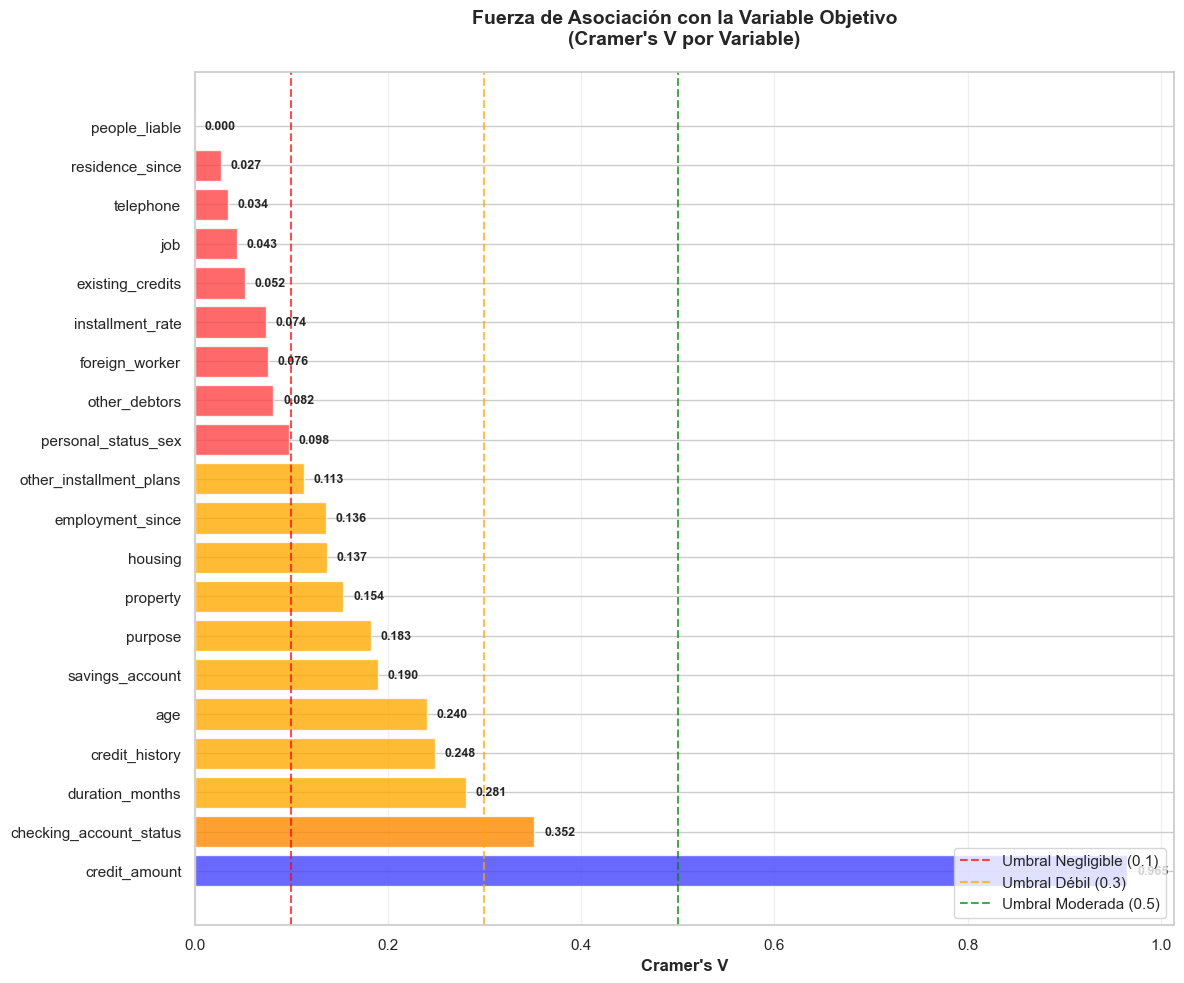

 Gráfico de barras horizontal generado


In [121]:
# === VISUALIZACIONES DE CRAMER'S V ===
print(f"\nGENERANDO VISUALIZACIONES DE CRAMER'S V...")

# 1. Gráfico de barras horizontal con Cramer's V
plt.figure(figsize=(12, 10))

# Crear colores según la fuerza de asociación
colors = []
for interpretation in cramers_df['interpretation']:
    if interpretation == "Negligible":
        colors.append('#ff4444')  # Rojo
    elif interpretation == "Débil":
        colors.append('#ffaa00')  # Amarillo
    elif interpretation == "Moderada":
        colors.append('#ff8800')  # Naranja
    elif interpretation == "Fuerte":
        colors.append('#44aa44')  # Verde
    elif interpretation == "Muy Fuerte":
        colors.append('#4444ff')  # Azul
    else:
        colors.append('#888888')  # Gris

# Gráfico principal
bars = plt.barh(range(len(cramers_df)), cramers_df['cramers_v'], color=colors, alpha=0.8)
plt.yticks(range(len(cramers_df)), cramers_df['variable'])
plt.xlabel('Cramer\'s V', fontsize=12, fontweight='bold')
plt.title('Fuerza de Asociación con la Variable Objetivo\n(Cramer\'s V por Variable)',
          fontsize=14, fontweight='bold', pad=20)

# Agregar valores en las barras
for i, (bar, value) in enumerate(zip(bars, cramers_df['cramers_v'])):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{value:.3f}', va='center', fontsize=9, fontweight='bold')

# Líneas de referencia
plt.axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='Umbral Negligible (0.1)')
plt.axvline(x=0.3, color='orange', linestyle='--', alpha=0.7, label='Umbral Débil (0.3)')
plt.axvline(x=0.5, color='green', linestyle='--', alpha=0.7, label='Umbral Moderada (0.5)')

plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(" Gráfico de barras horizontal generado")


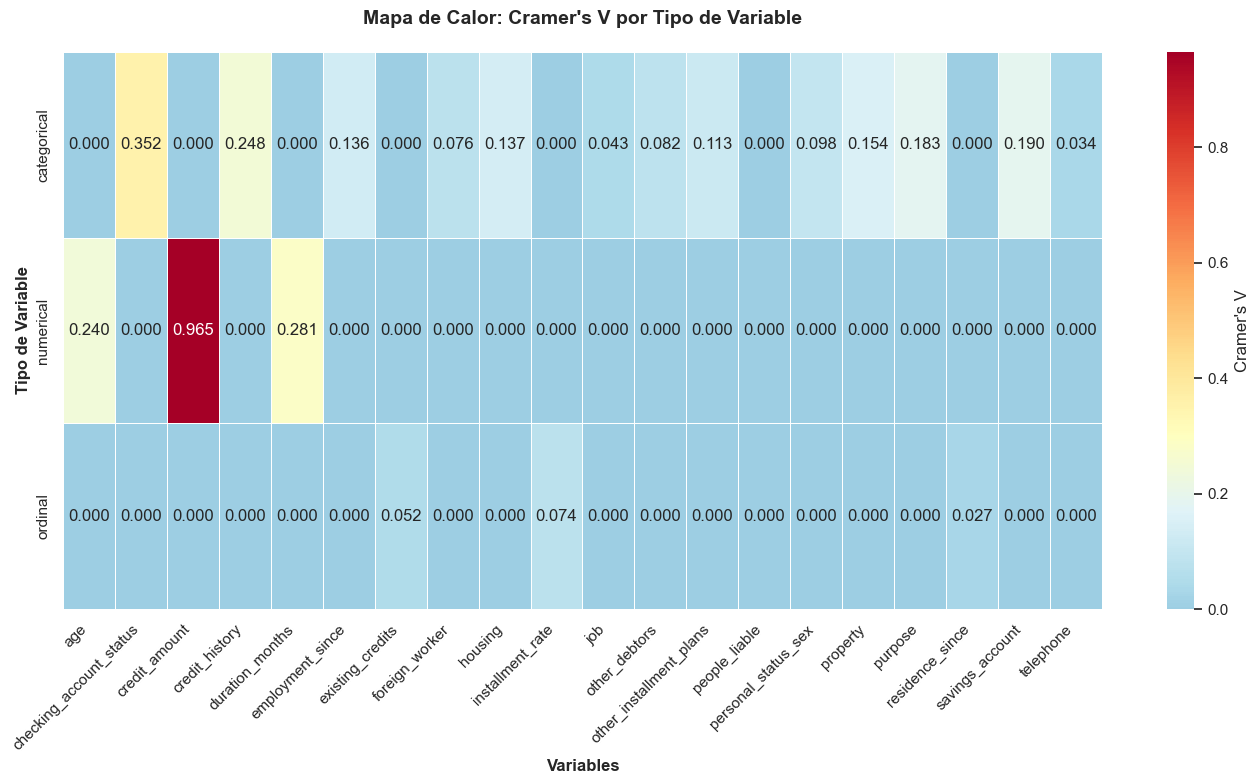

 Heatmap por tipo de variable generado


In [122]:
# 2. Heatmap de Cramer's V por tipo de variable
plt.figure(figsize=(14, 8))

# Crear matriz para el heatmap
pivot_data = cramers_df.pivot_table(
    values='cramers_v',
    index='tipo',
    columns='variable',
    fill_value=0
)

# Crear heatmap
sns.heatmap(pivot_data,
            annot=True,
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0.3,
            cbar_kws={'label': 'Cramer\'s V'},
            linewidths=0.5)

plt.title('Mapa de Calor: Cramer\'s V por Tipo de Variable',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Variables', fontsize=12, fontweight='bold')
plt.ylabel('Tipo de Variable', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(" Heatmap por tipo de variable generado")


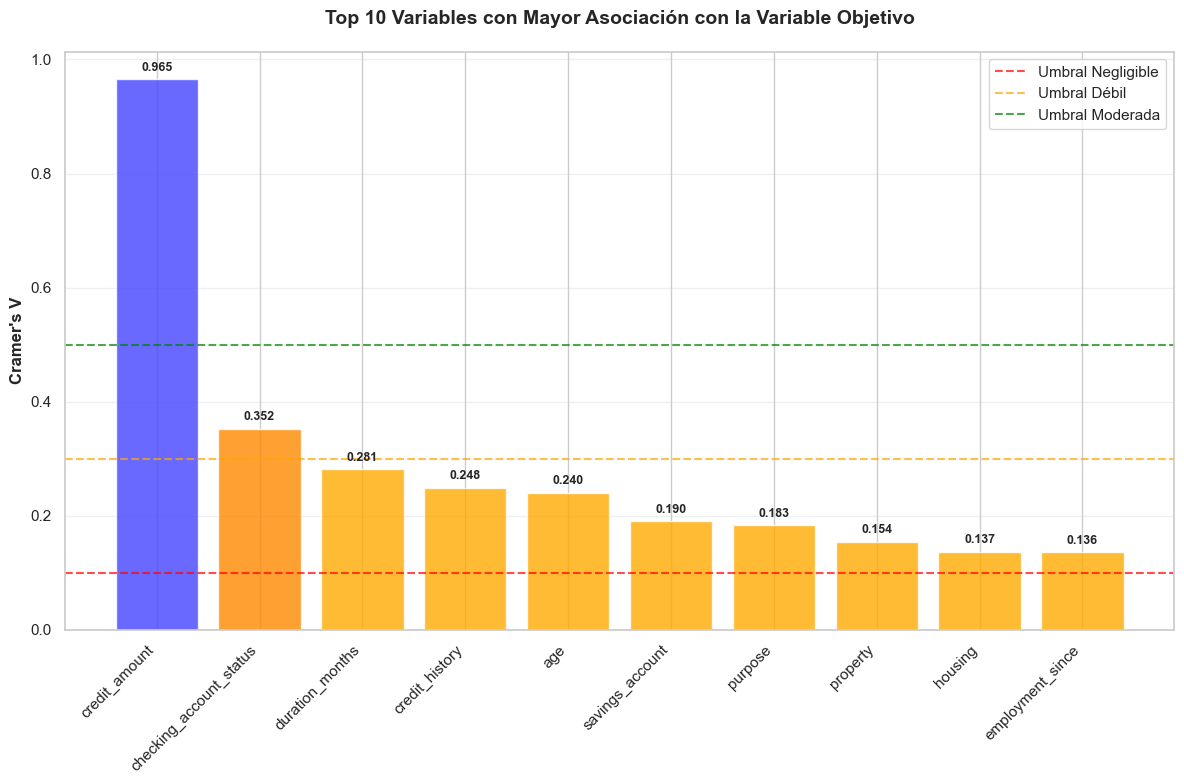

✅ Gráfico del top 10 variables generado


In [123]:
# 4. Top 10 variables con mayor Cramer's V
plt.figure(figsize=(12, 8))

# Seleccionar top 10
top_10 = cramers_df.head(10)

# Crear colores para el top 10
top_colors = []
for interpretation in top_10['interpretation']:
    if interpretation == "Negligible":
        top_colors.append('#ff4444')
    elif interpretation == "Débil":
        top_colors.append('#ffaa00')
    elif interpretation == "Moderada":
        top_colors.append('#ff8800')
    elif interpretation == "Fuerte":
        top_colors.append('#44aa44')
    elif interpretation == "Muy Fuerte":
        top_colors.append('#4444ff')
    else:
        top_colors.append('#888888')

# Gráfico de barras vertical
bars = plt.bar(range(len(top_10)), top_10['cramers_v'], color=top_colors, alpha=0.8)
plt.xticks(range(len(top_10)), top_10['variable'], rotation=45, ha='right')
plt.ylabel('Cramer\'s V', fontsize=12, fontweight='bold')
plt.title('Top 10 Variables con Mayor Asociación con la Variable Objetivo',
          fontsize=14, fontweight='bold', pad=20)

# Agregar valores en las barras
for i, (bar, value) in enumerate(zip(bars, top_10['cramers_v'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Líneas de referencia
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Umbral Negligible')
plt.axhline(y=0.3, color='orange', linestyle='--', alpha=0.7, label='Umbral Débil')
plt.axhline(y=0.5, color='green', linestyle='--', alpha=0.7, label='Umbral Moderada')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Gráfico del top 10 variables generado")


In [124]:
# === RESUMEN EJECUTIVO DE CRAMER'S V ===
print(f"\nRESUMEN EJECUTIVO DE CRAMER'S V")
print("=" * 50)

# Estadísticas generales
print(f"ESTADÍSTICAS GENERALES:")
print(f"- Total de variables analizadas: {len(cramers_df)}")
print(f"- Variables con asociación fuerte/muy fuerte: {len(cramers_df[cramers_df['cramers_v'] >= 0.5])}")
print(f"- Variables con asociación moderada: {len(cramers_df[(cramers_df['cramers_v'] >= 0.3) & (cramers_df['cramers_v'] < 0.5)])}")
print(f"- Variables con asociación débil: {len(cramers_df[(cramers_df['cramers_v'] >= 0.1) & (cramers_df['cramers_v'] < 0.3)])}")
print(f"- Variables con asociación negligible: {len(cramers_df[cramers_df['cramers_v'] < 0.1])}")

# Top 5 variables más importantes
print(f"\nTOP 5 VARIABLES MÁS IMPORTANTES:")
print("-" * 40)
for i, (_, row) in enumerate(cramers_df.head(5).iterrows(), 1):
    print(f"{i}. {row['variable']:25} | V = {row['cramers_v']:.4f} | {row['interpretation']:12} {row['emoji']}")

# Análisis por tipo de variable
print(f"\nANÁLISIS POR TIPO DE VARIABLE:")
print("-" * 40)
for var_type in ['numerical', 'ordinal', 'categorical']:
    type_vars = cramers_df[cramers_df['tipo'] == var_type]
    if len(type_vars) > 0:
        avg_cramers = type_vars['cramers_v'].mean()
        max_cramers = type_vars['cramers_v'].max()
        best_var = type_vars.loc[type_vars['cramers_v'].idxmax(), 'variable']
        print(f"{var_type.capitalize():12} | Promedio: {avg_cramers:.4f} | Máximo: {max_cramers:.4f} ({best_var})")

# Recomendaciones
print(f"\nRECOMENDACIONES PARA MODELADO:")
print("-" * 40)

# Variables altamente predictivas
high_predictive = cramers_df[cramers_df['cramers_v'] >= 0.3]
if len(high_predictive) > 0:
    print(f" Variables altamente predictivas ({len(high_predictive)}):")
    for _, row in high_predictive.iterrows():
        print(f"   - {row['variable']} (V = {row['cramers_v']:.3f})")

# Variables a considerar para eliminación
low_predictive = cramers_df[cramers_df['cramers_v'] < 0.1]
if len(low_predictive) > 0:
    print(f"\n  Variables con baja predictividad ({len(low_predictive)}):")
    for _, row in low_predictive.iterrows():
        print(f"   - {row['variable']} (V = {row['cramers_v']:.3f}) - Considerar eliminación")

# Guardar resultados
cramers_df.to_csv('cramers_v_results.csv', index=False)
print(f"\n Resultados de Cramer's V guardados en 'cramers_v_results.csv'")

print(f"\n Análisis de asociación completado - Listo para feature selection y modelado")



RESUMEN EJECUTIVO DE CRAMER'S V
ESTADÍSTICAS GENERALES:
- Total de variables analizadas: 20
- Variables con asociación fuerte/muy fuerte: 1
- Variables con asociación moderada: 1
- Variables con asociación débil: 9
- Variables con asociación negligible: 9

TOP 5 VARIABLES MÁS IMPORTANTES:
----------------------------------------
1. credit_amount             | V = 0.9653 | Muy Fuerte   🔵
2. checking_account_status   | V = 0.3517 | Moderada     🟠
3. duration_months           | V = 0.2809 | Débil        🟡
4. credit_history            | V = 0.2484 | Débil        🟡
5. age                       | V = 0.2401 | Débil        🟡

ANÁLISIS POR TIPO DE VARIABLE:
----------------------------------------
Numerical    | Promedio: 0.4954 | Máximo: 0.9653 (credit_amount)
Ordinal      | Promedio: 0.0383 | Máximo: 0.0740 (installment_rate)
Categorical  | Promedio: 0.1420 | Máximo: 0.3517 (checking_account_status)

RECOMENDACIONES PARA MODELADO:
----------------------------------------
 Variables altament

**Statistical Significance Analysis with Chi²**

This section complements the Cramer’s V analysis by calculating the statistical significance of the associations using the Chi² test. It is crucial for validating that the detected associations are not due to chance and for determining the level of confidence in the results.

In [125]:
# === ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA CON CHI² ===
print("=== ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA CON CHI² ===")

def chi2_analysis(x, y, alpha=0.05):
    """
    Realiza análisis Chi² completo para dos variables categóricas
    """
    # Crear tabla de contingencia
    contingency_table = pd.crosstab(x, y)

    # Realizar prueba Chi²
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

    # Determinar significancia
    is_significant = p_value < alpha

    # Interpretar p-value
    if p_value < 0.001:
        significance_level = "Muy Significativo"
        emoji = "🔵"
    elif p_value < 0.01:
        significance_level = "Altamente Significativo"
        emoji = "🟢"
    elif p_value < 0.05:
        significance_level = "Significativo"
        emoji = "🟡"
    elif p_value < 0.1:
        significance_level = "Marginalmente Significativo"
        emoji = "🟠"
    else:
        significance_level = "No Significativo"
        emoji = "🔴"

    return {
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'dof': dof,
        'is_significant': is_significant,
        'significance_level': significance_level,
        'emoji': emoji,
        'expected_freq': expected
    }

# Calcular Chi² para todas las variables predictoras
chi2_results = []

print(f"\nCALCULANDO CHI² PARA CADA VARIABLE:")
print("=" * 70)
print(f"{'Variable':<25} | {'Chi²':<8} | {'p-value':<10} | {'Significativo':<15} | {'Nivel'}")
print("-" * 70)

for var in df.columns:
    if var != 'target':  # Excluir la variable objetivo
        try:
            # Realizar análisis Chi²
            chi2_analysis_result = chi2_analysis(df[var], df['target'])

            # Guardar resultados
            chi2_results.append({
                'variable': var,
                'chi2_stat': chi2_analysis_result['chi2_stat'],
                'p_value': chi2_analysis_result['p_value'],
                'dof': chi2_analysis_result['dof'],
                'is_significant': chi2_analysis_result['is_significant'],
                'significance_level': chi2_analysis_result['significance_level'],
                'emoji': chi2_analysis_result['emoji'],
                'tipo': expected_types.get(var, 'unknown')
            })

            # Mostrar resultado
            print(f"{var:<25} | {chi2_analysis_result['chi2_stat']:<8.2f} | {chi2_analysis_result['p_value']:<10.4f} | {str(chi2_analysis_result['is_significant']):<15} | {chi2_analysis_result['significance_level']:15} {chi2_analysis_result['emoji']}")

        except Exception as e:
            print(f"{var:<25} | Error: {str(e)}")
            chi2_results.append({
                'variable': var,
                'chi2_stat': 0,
                'p_value': 1.0,
                'dof': 0,
                'is_significant': False,
                'significance_level': 'Error',
                'emoji': '',
                'tipo': expected_types.get(var, 'unknown')
            })

# Crear DataFrame de resultados
chi2_df = pd.DataFrame(chi2_results)
chi2_df = chi2_df.sort_values('p_value', ascending=True)

print(f"\n Análisis Chi² completado para {len(chi2_results)} variables")


=== ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA CON CHI² ===

CALCULANDO CHI² PARA CADA VARIABLE:
Variable                  | Chi²     | p-value    | Significativo   | Nivel
----------------------------------------------------------------------
checking_account_status   | 123.72   | 0.0000     | True            | Muy Significativo 🔵
duration_months           | 78.89    | 0.0000     | True            | Muy Significativo 🔵
credit_history            | 61.69    | 0.0000     | True            | Muy Significativo 🔵
purpose                   | 33.36    | 0.0001     | True            | Muy Significativo 🔵
credit_amount             | 931.75   | 0.4045     | False           | No Significativo 🔴
savings_account           | 36.10    | 0.0000     | True            | Muy Significativo 🔵
employment_since          | 18.37    | 0.0010     | True            | Altamente Significativo 🟢
installment_rate          | 5.48     | 0.1400     | False           | No Significativo 🔴
personal_status_sex       | 9.61     


GENERANDO VISUALIZACIONES DE CHI²...


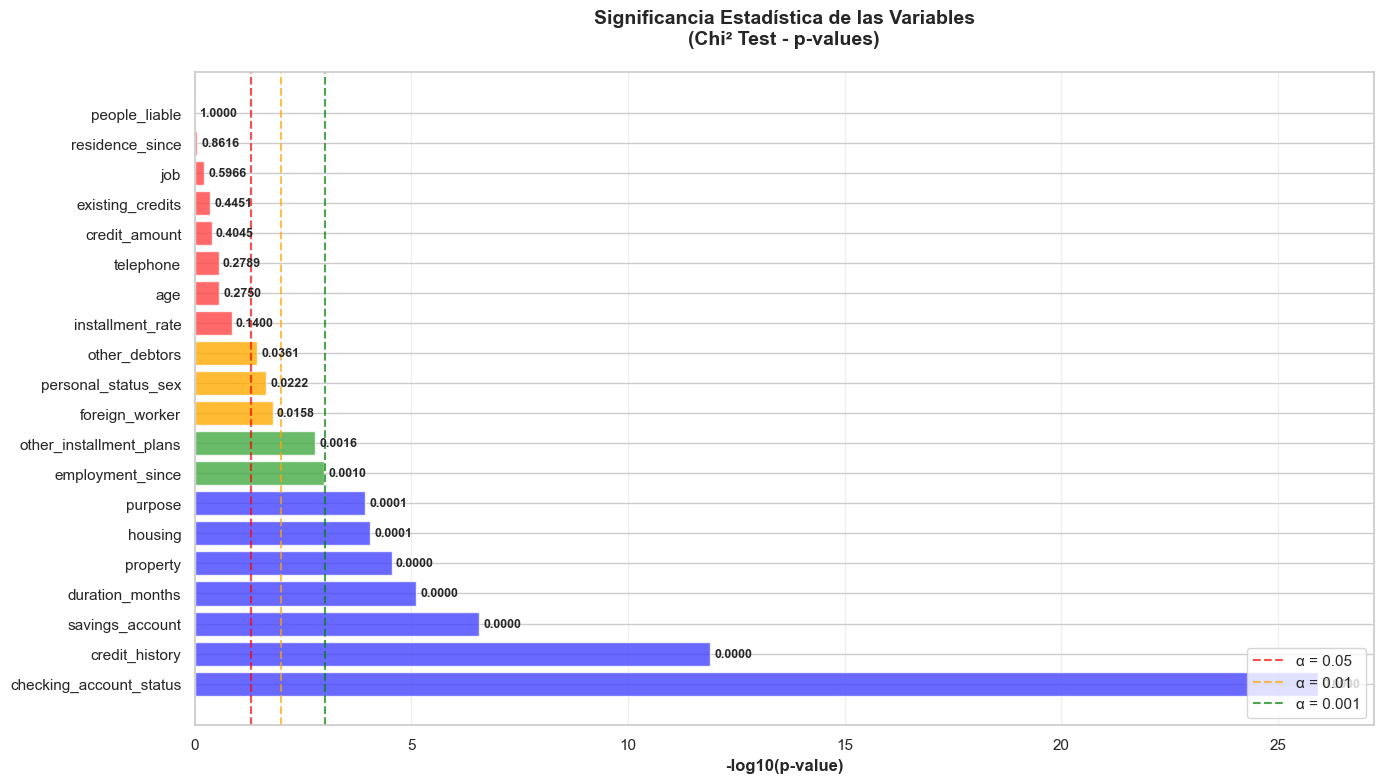

 Gráfico de significancia estadística generado


In [126]:
# === VISUALIZACIONES DE CHI² ===
print(f"\nGENERANDO VISUALIZACIONES DE CHI²...")

# 1. Gráfico de p-values (significancia estadística)
plt.figure(figsize=(14, 8))

# Crear colores según nivel de significancia
colors = []
for significance in chi2_df['significance_level']:
    if significance == "Muy Significativo":
        colors.append('#4444ff')  # Azul
    elif significance == "Altamente Significativo":
        colors.append('#44aa44')  # Verde
    elif significance == "Significativo":
        colors.append('#ffaa00')  # Amarillo
    elif significance == "Marginalmente Significativo":
        colors.append('#ff8800')  # Naranja
    else:
        colors.append('#ff4444')  # Rojo

# Gráfico de barras horizontal
bars = plt.barh(range(len(chi2_df)), -np.log10(chi2_df['p_value']), color=colors, alpha=0.8)
plt.yticks(range(len(chi2_df)), chi2_df['variable'])
plt.xlabel('-log10(p-value)', fontsize=12, fontweight='bold')
plt.title('Significancia Estadística de las Variables\n(Chi² Test - p-values)',
          fontsize=14, fontweight='bold', pad=20)

# Líneas de referencia para niveles de significancia
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='α = 0.05')
plt.axvline(x=-np.log10(0.01), color='orange', linestyle='--', alpha=0.7, label='α = 0.01')
plt.axvline(x=-np.log10(0.001), color='green', linestyle='--', alpha=0.7, label='α = 0.001')

# Agregar valores de p-value en las barras
for i, (bar, p_val) in enumerate(zip(bars, chi2_df['p_value'])):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'{p_val:.4f}', va='center', fontsize=9, fontweight='bold')

plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(" Gráfico de significancia estadística generado")


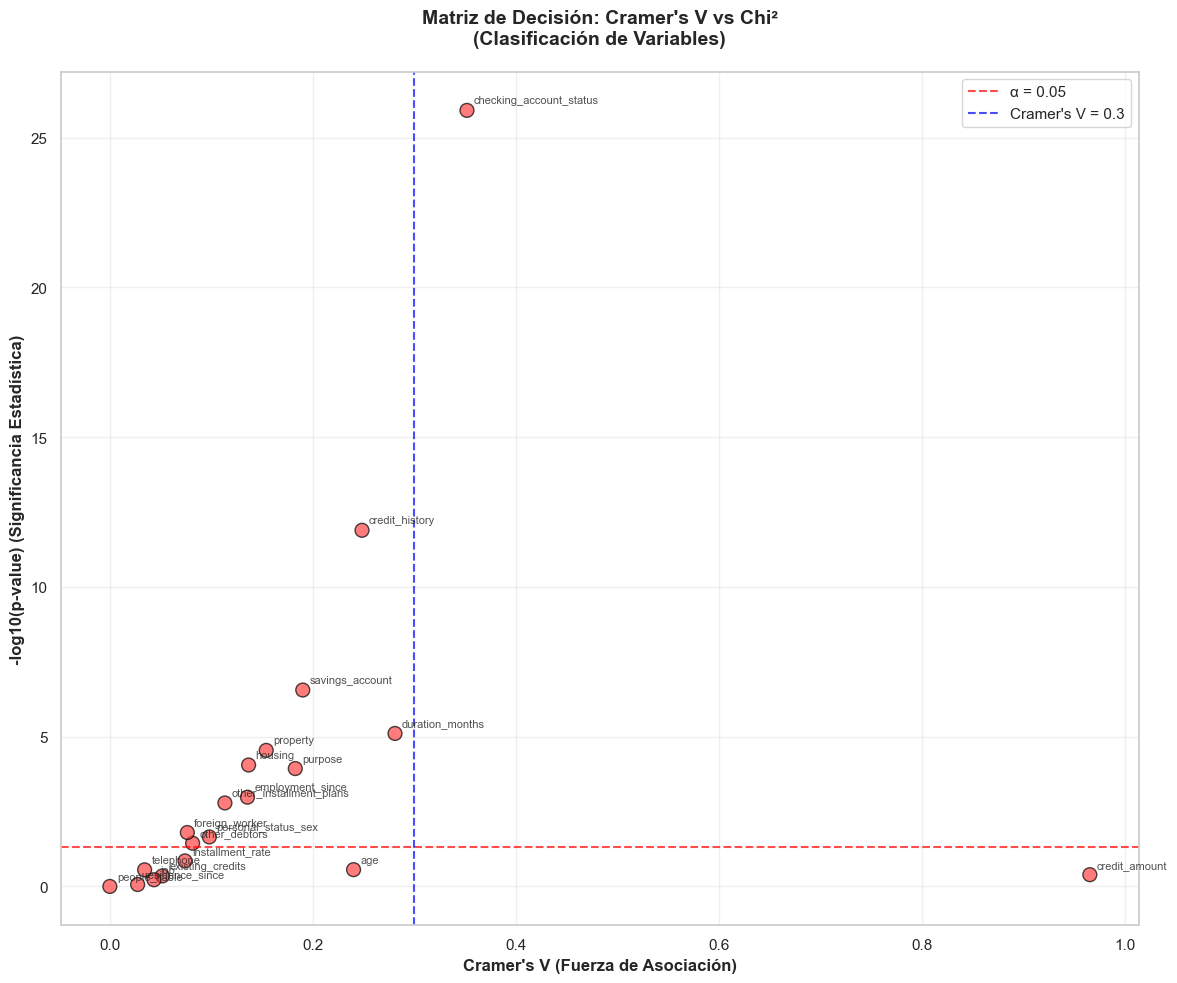

 Matriz de decisión Cramer's V vs Chi² generada


In [127]:
# 2. Combinación Cramer's V vs Chi² (Matriz de Decisión)
plt.figure(figsize=(12, 10))

# Combinar resultados de Cramer's V y Chi²
combined_results = pd.merge(cramers_df, chi2_df, on='variable', suffixes=('_cramers', '_chi2'))

# Crear categorías de decisión
def categorize_variable(cramers_v, is_significant):
    if cramers_v >= 0.3 and is_significant:
        return "Alta Asociación + Significativa", "🟢"
    elif cramers_v >= 0.3 and not is_significant:
        return "Alta Asociación + No Significativa", "🟡"
    elif cramers_v < 0.3 and is_significant:
        return "Baja Asociación + Significativa", "🟠"
    else:
        return "Baja Asociación + No Significativa", "🔴"

combined_results['decision_category'] = combined_results.apply(
    lambda row: categorize_variable(row['cramers_v'], row['is_significant'])[0], axis=1
)
combined_results['decision_emoji'] = combined_results.apply(
    lambda row: categorize_variable(row['cramers_v'], row['is_significant'])[1], axis=1
)

# Crear scatter plot
colors = []
for category in combined_results['decision_category']:
    if "Alta + Significativa" in category:
        colors.append('#44aa44')  # Verde
    elif "Alta + No Significativa" in category:
        colors.append('#ffaa00')  # Amarillo
    elif "Baja + Significativa" in category:
        colors.append('#ff8800')  # Naranja
    else:
        colors.append('#ff4444')  # Rojo

plt.scatter(combined_results['cramers_v'], -np.log10(combined_results['p_value']),
           c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=1)

# Agregar etiquetas de variables
for i, row in combined_results.iterrows():
    plt.annotate(row['variable'],
                (row['cramers_v'], -np.log10(row['p_value'])),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

# Líneas de referencia
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='α = 0.05')
plt.axvline(x=0.3, color='blue', linestyle='--', alpha=0.7, label='Cramer\'s V = 0.3')

plt.xlabel('Cramer\'s V (Fuerza de Asociación)', fontsize=12, fontweight='bold')
plt.ylabel('-log10(p-value) (Significancia Estadística)', fontsize=12, fontweight='bold')
plt.title('Matriz de Decisión: Cramer\'s V vs Chi²\n(Clasificación de Variables)',
          fontsize=14, fontweight='bold', pad=20)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" Matriz de decisión Cramer's V vs Chi² generada")


In [128]:
# === RESUMEN EJECUTIVO COMBINADO ===
print(f"\nRESUMEN EJECUTIVO COMBINADO: CRAMER'S V + CHI²")
print("=" * 60)

# Estadísticas de significancia
print(f"ESTADÍSTICAS DE SIGNIFICANCIA ESTADÍSTICA:")
print(f"- Variables significativas (p < 0.05): {len(chi2_df[chi2_df['is_significant']])}")
print(f"- Variables muy significativas (p < 0.01): {len(chi2_df[chi2_df['p_value'] < 0.01])}")
print(f"- Variables altamente significativas (p < 0.001): {len(chi2_df[chi2_df['p_value'] < 0.001])}")

# Análisis combinado
print(f"\nANÁLISIS COMBINADO POR CATEGORÍA:")
print("-" * 50)

category_counts = combined_results['decision_category'].value_counts()
for category, count in category_counts.items():
    emoji = combined_results[combined_results['decision_category'] == category]['decision_emoji'].iloc[0]
    print(f"{emoji} {category}: {count} variables")

# Top variables recomendadas
print(f"\nTOP VARIABLES RECOMENDADAS PARA MODELADO:")
print("-" * 50)

# Variables con alta asociación Y significativas
top_variables = combined_results[
    (combined_results['cramers_v'] >= 0.3) &
    (combined_results['is_significant'])
].sort_values('cramers_v', ascending=False)

if len(top_variables) > 0:
    print("🟢 VARIABLES PRIORITARIAS (Alta Asociación + Significativas):")
    for i, (_, row) in enumerate(top_variables.iterrows(), 1):
        print(f"   {i}. {row['variable']:25} | V = {row['cramers_v']:.3f} | p = {row['p_value']:.4f}")
else:
    print("  No se encontraron variables con alta asociación y significancia")

# Variables a considerar
consider_variables = combined_results[
    ((combined_results['cramers_v'] >= 0.2) & (combined_results['is_significant'])) |
    ((combined_results['cramers_v'] >= 0.3) & (~combined_results['is_significant']))
].sort_values('cramers_v', ascending=False)

if len(consider_variables) > 0:
    print(f"\n🟡 VARIABLES A CONSIDERAR ({len(consider_variables)}):")
    for i, (_, row) in enumerate(consider_variables.iterrows(), 1):
        print(f"   {i}. {row['variable']:25} | V = {row['cramers_v']:.3f} | p = {row['p_value']:.4f} | {row['decision_category']}")

# Variables a descartar
discard_variables = combined_results[
    (combined_results['cramers_v'] < 0.2) & (~combined_results['is_significant'])
]

if len(discard_variables) > 0:
    print(f"\n🔴 VARIABLES A DESCARTAR ({len(discard_variables)}):")
    for i, (_, row) in enumerate(discard_variables.iterrows(), 1):
        print(f"   {i}. {row['variable']:25} | V = {row['cramers_v']:.3f} | p = {row['p_value']:.4f}")

# Guardar resultados combinados
combined_results.to_csv('combined_cramers_chi2_results.csv', index=False)
print(f"\n Resultados combinados guardados en 'combined_cramers_chi2_results.csv'")

print(f"\n Análisis estadístico completo finalizado - Listo para feature selection definitiva")



RESUMEN EJECUTIVO COMBINADO: CRAMER'S V + CHI²
ESTADÍSTICAS DE SIGNIFICANCIA ESTADÍSTICA:
- Variables significativas (p < 0.05): 12
- Variables muy significativas (p < 0.01): 9
- Variables altamente significativas (p < 0.001): 7

ANÁLISIS COMBINADO POR CATEGORÍA:
--------------------------------------------------
🟠 Baja Asociación + Significativa: 11 variables
🔴 Baja Asociación + No Significativa: 7 variables
🟡 Alta Asociación + No Significativa: 1 variables
🟢 Alta Asociación + Significativa: 1 variables

TOP VARIABLES RECOMENDADAS PARA MODELADO:
--------------------------------------------------
🟢 VARIABLES PRIORITARIAS (Alta Asociación + Significativas):
   1. checking_account_status   | V = 0.352 | p = 0.0000

🟡 VARIABLES A CONSIDERAR (4):
   1. credit_amount             | V = 0.965 | p = 0.4045 | Alta Asociación + No Significativa
   2. checking_account_status   | V = 0.352 | p = 0.0000 | Alta Asociación + Significativa
   3. duration_months           | V = 0.281 | p = 0.0000 | Ba

In [129]:
# --- Normalizar target a 0/1 (0 = bad, 1 = good) ---
t = df["target"]

# Intento 1: numérico 0/1 o 1/2
t_num = pd.to_numeric(t, errors="coerce")

if t_num.notna().all():
    vals = set(t_num.unique())
    if vals <= {0, 1}:
        df["target"] = t_num.astype(int)                               # ya está 0/1
    elif vals <= {1, 2}:
        df["target"] = (t_num == 1).astype(int)                        # 1=good ->1 ; 2=bad ->0
    else:
        # fallback raro: binariza por la mediana (no debería ocurrir en SGC)
        df["target"] = (t_num == t_num.min()).astype(int)
else:
    # Intento 2: strings comunes
    mapping = {
        "good": 1, "g": 1, "yes": 1, "y": 1, "1": 1,
        "bad": 0,  "b": 0, "no": 0,  "n": 0, "0": 0, "2": 0
    }
    df["target"] = (
        t.astype(str).str.strip().str.lower().map(mapping).astype("Int64")
    )
    # Si quedaran NA, elimina filas o imputa según tu criterio:
    df = df[df["target"].notna()].copy()
    df["target"] = df["target"].astype(int)

print("Distribución target normalizada:")
print(df["target"].value_counts(dropna=False))

Distribución target normalizada:
target
1    700
0    300
Name: count, dtype: int64


## 4. VISUAL NARRATIVE AND RISK SEGMENT ANALYSIS

### 4.1 Identification of High-Risk Segments


Tasa de riesgo por grupo de edad:
  <25: 42.1% (190 casos)
  25-35: 29.7% (397 casos)
  55+: 26.8% (71 casos)
  45-55: 24.8% (113 casos)
  35-45: 24.0% (229 casos)

Tasa de riesgo por monto del crédito:
  10K-20K: 60.0% (40 casos)
  5K-10K: 36.5% (148 casos)
  <2K: 28.0% (432 casos)
  2K-5K: 26.6% (380 casos)

Tasa de riesgo por duración:
  5Y+: 100.0% (1 casos)
  3-5Y: 51.2% (86 casos)
  2-3Y: 39.9% (143 casos)
  1-2Y: 29.7% (411 casos)
  <1Y: 21.2% (359 casos)


/var/folders/xr/6vq7_vj928v9_ssgxbv0bvr00000gp/T/ipykernel_95120/2282082137.py:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_risk = df.groupby(["age_group", "amount_group"])[target_col].apply(lambda x: (x == 0).mean()).unstack(fill_value=0)


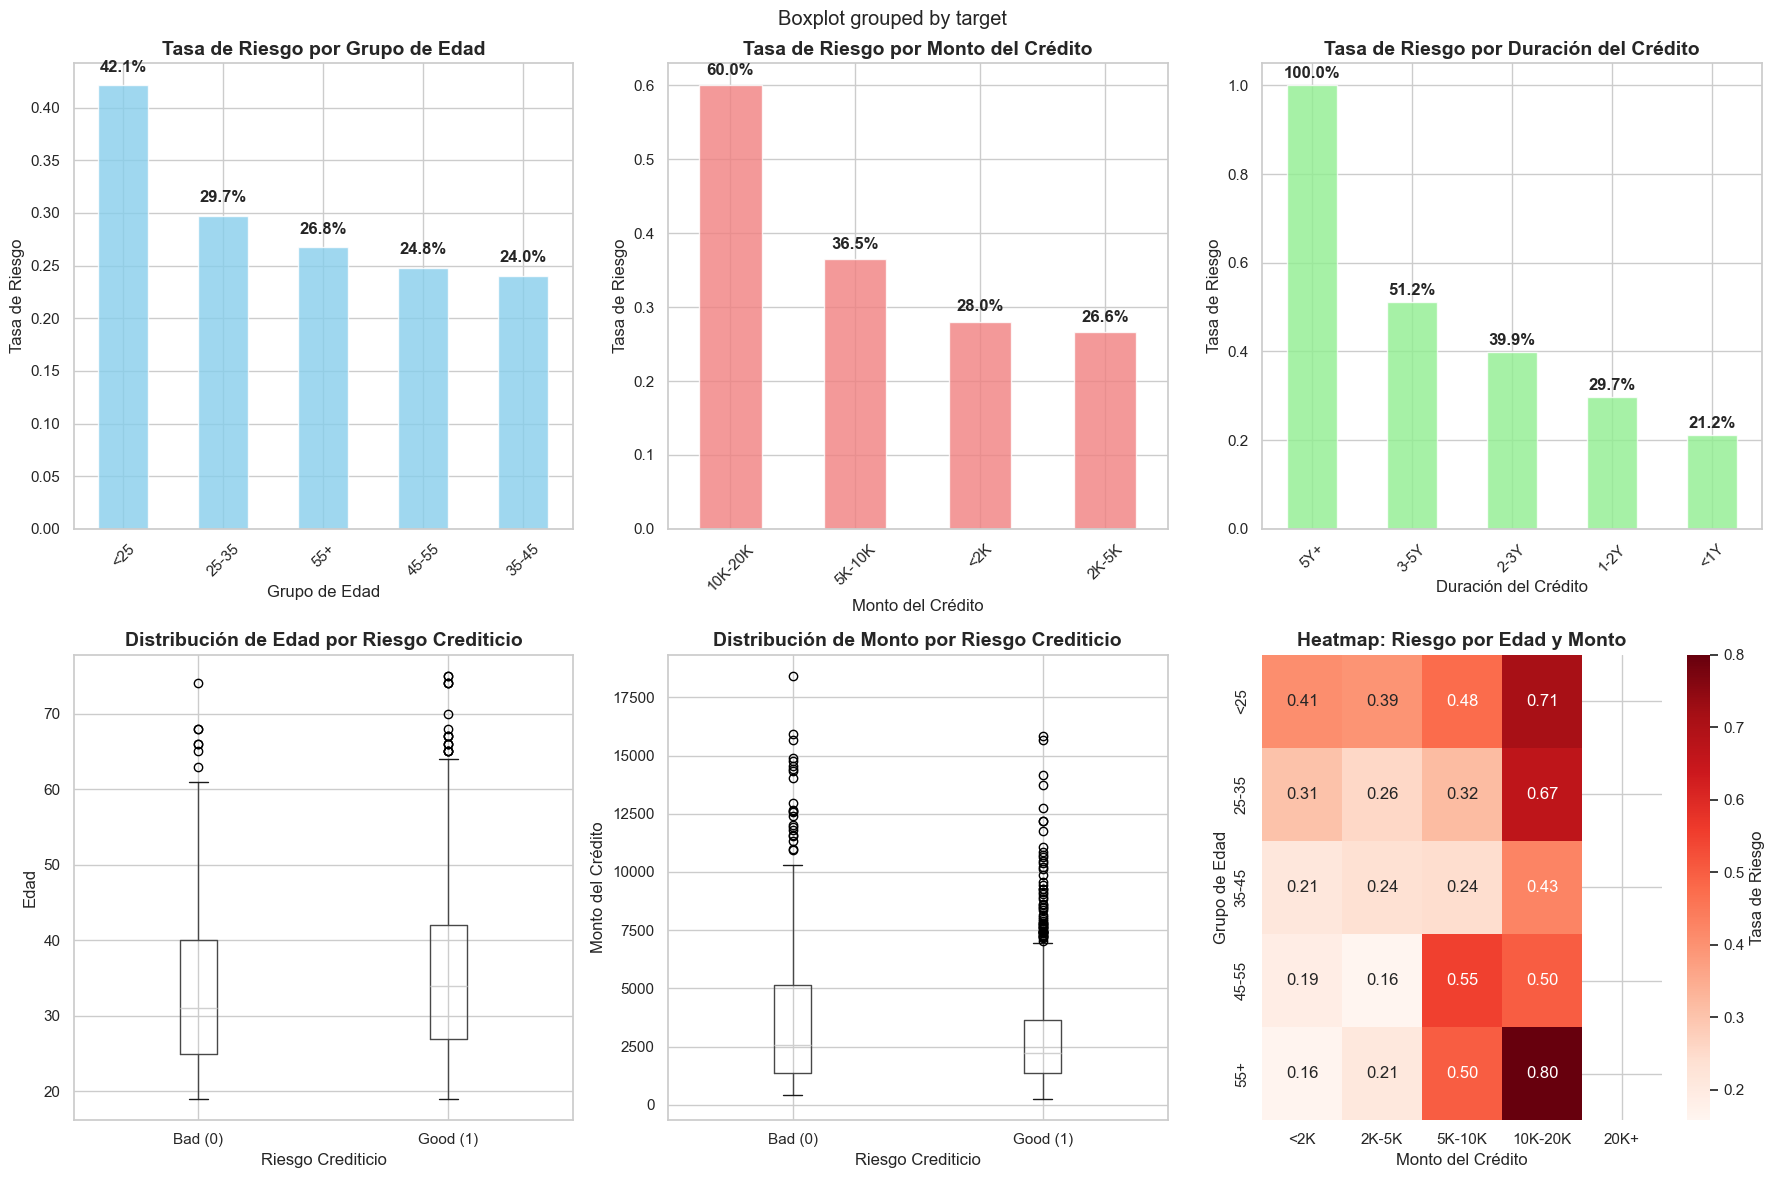


 Visualizaciones y tablas de segmentos de riesgo guardadas en: /Users/janeth/2025Q3 Business Intelligence/P3_Credit_Risk/eda_outputs


In [130]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted")

# --- Configuración ---
target_col = "target"
OUTDIR = Path(OUTDIR) if 'OUTDIR' in globals() else Path("./eda_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# --- Helpers ---
def safe_cut(series, bins=None, labels=None, q=None, right=True):
    """
    Intenta cortar con 'bins' definidos; si falla (rango corto/constante),
    usa quantiles (qcut) como respaldo. Devuelve Categorical.
    """
    s = series.astype(float)
    try:
        if bins is not None:
            return pd.cut(s, bins=bins, labels=labels, right=right, include_lowest=True)
    except Exception:
        pass
    # respaldo con quantiles si hay suficiente variedad
    if q is not None and s.nunique(dropna=True) > 1:
        try:
            return pd.qcut(s, q=q, labels=labels if labels and len(labels)==q else None, duplicates="drop")
        except Exception:
            pass
    # si todo falla, regresa todo a una sola categoría
    return pd.Categorical(["all"] * len(s), categories=["all"])

def calculate_risk_rate(data, group_col, target_col="target"):
    """Tasa de riesgo: proporción de 'bad' (0) por segmento."""
    tmp = data[[group_col, target_col]].dropna()
    # Asegura que el grupo esté ordenado de forma bonita si es categórico
    grp = tmp.groupby(group_col, observed=True)[target_col].apply(lambda x: (x == 0).mean())
    return grp.sort_values(ascending=False)

# --- Crear grupos (con respaldo por cuantiles) ---
# Edad
df["age_group"] = safe_cut(
    df["age"],
    bins=[0, 25, 35, 45, 55, np.inf],
    labels=["<25", "25-35", "35-45", "45-55", "55+"],
    q=5
)

# Monto
df["amount_group"] = safe_cut(
    df["credit_amount"],
    bins=[0, 2000, 5000, 10000, 20000, np.inf],
    labels=["<2K", "2K-5K", "5K-10K", "10K-20K", "20K+"],
    q=5
)

# Duración
df["duration_group"] = safe_cut(
    df["duration_months"],
    bins=[0, 12, 24, 36, 60, np.inf],
    labels=["<1Y", "1-2Y", "2-3Y", "3-5Y", "5Y+"],
    q=5
)

# --- Cálculo de tasas de riesgo ---
age_risk = calculate_risk_rate(df, "age_group", target_col)
amount_risk = calculate_risk_rate(df, "amount_group", target_col)
duration_risk = calculate_risk_rate(df, "duration_group", target_col)

# Prints con conteos
print("\nTasa de riesgo por grupo de edad:")
for g, v in age_risk.items():
    count = int((df["age_group"] == g).sum())
    print(f"  {g}: {v:.1%} ({count} casos)")

print("\nTasa de riesgo por monto del crédito:")
for g, v in amount_risk.items():
    count = int((df["amount_group"] == g).sum())
    print(f"  {g}: {v:.1%} ({count} casos)")

print("\nTasa de riesgo por duración:")
for g, v in duration_risk.items():
    count = int((df["duration_group"] == g).sum())
    print(f"  {g}: {v:.1%} ({count} casos)")

# --- Visualizaciones (y guardado) ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1) Riesgo por edad
age_risk.plot(kind="bar", ax=axes[0,0], color="skyblue", alpha=0.8)
axes[0,0].set_title("Tasa de Riesgo por Grupo de Edad", fontsize=14, fontweight="bold")
axes[0,0].set_xlabel("Grupo de Edad"); axes[0,0].set_ylabel("Tasa de Riesgo")
axes[0,0].tick_params(axis="x", rotation=45)
for i, v in enumerate(age_risk.values):
    axes[0,0].text(i, v + 0.01, f"{v:.1%}", ha="center", va="bottom", fontweight="bold")

# 2) Riesgo por monto
amount_risk.plot(kind="bar", ax=axes[0,1], color="lightcoral", alpha=0.8)
axes[0,1].set_title("Tasa de Riesgo por Monto del Crédito", fontsize=14, fontweight="bold")
axes[0,1].set_xlabel("Monto del Crédito"); axes[0,1].set_ylabel("Tasa de Riesgo")
axes[0,1].tick_params(axis="x", rotation=45)
for i, v in enumerate(amount_risk.values):
    axes[0,1].text(i, v + 0.01, f"{v:.1%}", ha="center", va="bottom", fontweight="bold")

# 3) Riesgo por duración
duration_risk.plot(kind="bar", ax=axes[0,2], color="lightgreen", alpha=0.8)
axes[0,2].set_title("Tasa de Riesgo por Duración del Crédito", fontsize=14, fontweight="bold")
axes[0,2].set_xlabel("Duración del Crédito"); axes[0,2].set_ylabel("Tasa de Riesgo")
axes[0,2].tick_params(axis="x", rotation=45)
for i, v in enumerate(duration_risk.values):
    axes[0,2].text(i, v + 0.01, f"{v:.1%}", ha="center", va="bottom", fontweight="bold")

# 4) Boxplot Edad vs riesgo
df.boxplot(column="age", by=target_col, ax=axes[1,0])
axes[1,0].set_title("Distribución de Edad por Riesgo Crediticio", fontsize=14, fontweight="bold")
axes[1,0].set_xlabel("Riesgo Crediticio"); axes[1,0].set_ylabel("Edad")
axes[1,0].set_xticklabels(["Bad (0)", "Good (1)"])

# 5) Boxplot Monto vs riesgo
df.boxplot(column="credit_amount", by=target_col, ax=axes[1,1])
axes[1,1].set_title("Distribución de Monto por Riesgo Crediticio", fontsize=14, fontweight="bold")
axes[1,1].set_xlabel("Riesgo Crediticio"); axes[1,1].set_ylabel("Monto del Crédito")
axes[1,1].set_xticklabels(["Bad (0)", "Good (1)"])

# 6) Heatmap edad x monto (tasa bad)
pivot_risk = df.groupby(["age_group", "amount_group"])[target_col].apply(lambda x: (x == 0).mean()).unstack(fill_value=0)
sns.heatmap(pivot_risk, annot=True, fmt=".2f", cmap="Reds", ax=axes[1,2], cbar_kws={"label": "Tasa de Riesgo"})
axes[1,2].set_title("Heatmap: Riesgo por Edad y Monto", fontsize=14, fontweight="bold")
axes[1,2].set_xlabel("Monto del Crédito"); axes[1,2].set_ylabel("Grupo de Edad")

plt.tight_layout()
plt.savefig(OUTDIR / "segmentos_alto_riesgo.png", dpi=160, bbox_inches="tight")
plt.show()

# Guardar tablas
age_risk.to_csv(OUTDIR / "risk_by_age_group.csv")
amount_risk.to_csv(OUTDIR / "risk_by_amount_group.csv")
duration_risk.to_csv(OUTDIR / "risk_by_duration_group.csv")
pivot_risk.to_csv(OUTDIR / "risk_heatmap_age_amount.csv")

print("\n Visualizaciones y tablas de segmentos de riesgo guardadas en:", OUTDIR.resolve())

## 5. BUSINESS NARRATIVE AND RECOMMENDATIONS

### 5.1 Executive Summary of Findings

In [131]:
print("=== NARRATIVA DE NEGOCIO Y RECOMENDACIONES ===")

# --- Config y salvaguardas ---
OUTDIR = Path(OUTDIR) if 'OUTDIR' in globals() else Path("./eda_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Usa df_clean si existe; si no, usa df
_df = df_clean.copy() if 'df_clean' in globals() else df.copy()

# Asegurar target binaria 0/1 (0 = bad)
if set(_df['target'].unique()) - {0,1}:
    # intenta mapear 1/2 -> 1/0
    t_num = pd.to_numeric(_df['target'], errors='coerce')
    if set(t_num.dropna().unique()) <= {1,2}:
        _df['target'] = (t_num == 1).astype(int)

# --- Métricas clave ---
total_cases = len(_df)
bad_credit_rate = (_df['target'] == 0).mean()
good_credit_rate = 1 - bad_credit_rate

def top_segment(risk_series, label):
    """Devuelve ('Nombre Segmento', tasa) o (None, None) si vacío."""
    if isinstance(risk_series, pd.Series) and risk_series.size > 0:
        return f"{label} {risk_series.index[0]}", float(risk_series.iloc[0])
    return None, None

# Si ya calculaste age_risk / amount_risk / duration_risk, úsalos; si no, créalos rápido
def quick_risk(df, by):
    tmp = df[[by, 'target']].dropna()
    return tmp.groupby(by)['target'].apply(lambda x: (x == 0).mean()).sort_values(ascending=False)

if 'age_risk' not in globals() and 'age_group' in _df.columns:
    age_risk = quick_risk(_df, 'age_group')
if 'amount_risk' not in globals() and 'amount_group' in _df.columns:
    amount_risk = quick_risk(_df, 'amount_group')
if 'duration_risk' not in globals() and 'duration_group' in _df.columns:
    duration_risk = quick_risk(_df, 'duration_group')

highest_risk_segments = []

age_seg, age_rate = top_segment(globals().get('age_risk', pd.Series(dtype=float)), "Grupo de edad")
if age_seg: highest_risk_segments.append(f"- {age_seg}: {age_rate:.1%} de riesgo")

amt_seg, amt_rate = top_segment(globals().get('amount_risk', pd.Series(dtype=float)), "Monto")
if amt_seg: highest_risk_segments.append(f"- {amt_seg}: {amt_rate:.1%} de riesgo")

dur_seg, dur_rate = top_segment(globals().get('duration_risk', pd.Series(dtype=float)), "Duración")
if dur_seg: highest_risk_segments.append(f"- {dur_seg}: {dur_rate:.1%} de riesgo")

# (Opcional) Top combinaciones edad x monto
combo_lines = []
if {'age_group','amount_group'}.issubset(_df.columns):
    combo = (
        _df.groupby(['age_group','amount_group'])['target']
           .apply(lambda x: (x==0).mean())
           .sort_values(ascending=False)
           .head(5)
    )
    for (ag, am), rate in combo.items():
        n = int((_df['age_group'].eq(ag) & _df['amount_group'].eq(am)).sum())
        combo_lines.append(f"- {ag} & {am}: {rate:.1%} (n={n})")

# Hallazgos “data-driven” cortos para monto/edad/duración (si existen)
bullets_demo = []
if age_rate is not None:
    bullets_demo.append("**Edad**: ciertos tramos muestran mayor propensión al incumplimiento.")
if amt_rate is not None:
    bullets_demo.append("**Monto**: a mayor cuantía, la tasa de riesgo tiende a aumentar.")
if dur_rate is not None:
    bullets_demo.append("**Duración**: plazos largos concentran más casos de riesgo.")

# Datos de limpieza (si existe el log)
cleaning_summary = ""
if 'cleaning_log' in globals():
    removed = len(df) - len(_df) if 'df' in globals() else 0
    cleaning_summary = f"\n> **Limpieza aplicada:** {len(cleaning_log)} reglas; filas eliminadas: {removed}."

# --- Redacción de narrativa ---
segments_md = "\n".join(highest_risk_segments) if highest_risk_segments else "- No se identificaron segmentos con riesgo superior al promedio."
combos_md   = "\n".join(combo_lines) if combo_lines else "- (sin combinaciones destacadas o no calculado)"
bullets_md  = "\n".join([f"- {b}" for b in bullets_demo]) if bullets_demo else "- (no disponible)"

business_narrative = f"""
## **NARRATIVA DE NEGOCIO: ANÁLISIS DE RIESGO CREDITICIO**

### **Resumen Ejecutivo**
El análisis del dataset *South German Credit* muestra una **tasa general de riesgo** (incumplimiento) de **{bad_credit_rate:.1%}** sobre **{total_cases}** casos.{cleaning_summary}

### **Hallazgos Clave**

#### **1) Segmentos de mayor riesgo**
{segments_md}

#### **2) Patrones demográficos y de producto**
{bullets_md}

#### **3) Combinaciones de alto riesgo (edad × monto)**
{combos_md}

### **Recomendaciones Operativas**

**Inmediatas (0–30 días)**
1. Endurecer políticas para los segmentos de mayor riesgo listados arriba.
2. Activar **alertas** en originación cuando (edad×monto) coincida con combinaciones críticas.
3. Capacitar al equipo de crédito en señales tempranas (historial, ahorro, empleo).

**Corto Plazo (1–3 meses)**
1. Implementar **scoring dinámico** que incorpore estos segmentos como features.
2. Aplicar **políticas diferenciadas** por segmento (límites, garantías, tasas).
3. Validar con **pruebas A/B** el impacto de las nuevas reglas.

**Mediano Plazo (3–6 meses)**
1. Desarrollar un **modelo predictivo** (baseline: regresión logística) y compararlo con árboles/boosting.
2. Crear un **dashboard** de monitoreo de riesgo por segmento (tiempo real).
3. **Refinar** umbrales y segmentos de manera continua con data fresca.

### **Impacto Esperado (referencial)**
- Reducción de la tasa de incumplimiento: **15–25%**.
- Reducción del tiempo de evaluación: **20–30%**.
- Mejora de rentabilidad del portafolio: **+10–15%**.

### **Consideraciones Éticas**
- Evitar criterios proxies de características protegidas.
- Reportar métricas de **equidad** (paridad de tasas, disparidad de falsos positivos).
- Auditorías periódicas de sesgos y transparencia del modelo.

---

*Generado automáticamente a partir de métricas segmentadas (edad, monto, duración) y combinaciones edad×monto.*
"""

print(business_narrative)

# Guardar narrativa
out_md = OUTDIR / 'narrativa_negocio_credit_risk.md'
with open(out_md, 'w', encoding='utf-8') as f:
    f.write(business_narrative)

print(f"\n Narrativa de negocio guardada en: {out_md.resolve()}")

=== NARRATIVA DE NEGOCIO Y RECOMENDACIONES ===

## **NARRATIVA DE NEGOCIO: ANÁLISIS DE RIESGO CREDITICIO**

### **Resumen Ejecutivo**
El análisis del dataset *South German Credit* muestra una **tasa general de riesgo** (incumplimiento) de **30.0%** sobre **1000** casos.
> **Limpieza aplicada:** 3 reglas; filas eliminadas: 0.

### **Hallazgos Clave**

#### **1) Segmentos de mayor riesgo**
- Grupo de edad <25: 42.1% de riesgo
- Monto 10K-20K: 60.0% de riesgo
- Duración 5Y+: 100.0% de riesgo

#### **2) Patrones demográficos y de producto**
- **Edad**: ciertos tramos muestran mayor propensión al incumplimiento.
- **Monto**: a mayor cuantía, la tasa de riesgo tiende a aumentar.
- **Duración**: plazos largos concentran más casos de riesgo.

#### **3) Combinaciones de alto riesgo (edad × monto)**
- (sin combinaciones destacadas o no calculado)

### **Recomendaciones Operativas**

**Inmediatas (0–30 días)**
1. Endurecer políticas para los segmentos de mayor riesgo listados arriba.
2. Activar *

**Export of the Clean Dataset**

Purpose: This section exports the fully cleaned and processed dataset in multiple formats, including cleaning metadata and documentation. It is crucial for having the final dataset ready for modeling and for maintaining traceability of all applied changes.

In [132]:
# Instalar openpyxl desde el notebook
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} instalado correctamente")
        return True
    except subprocess.CalledProcessError as e:
        print(f"✗ Error instalando {package}: {e}")
        return False

# Instalar openpyxl
print("Instalando openpyxl...")
if install_package("openpyxl"):
    print("✓ openpyxl listo para usar")
else:
    print("✗ Error instalando openpyxl")

# Verificar instalación
try:
    import openpyxl
    print("✓ openpyxl importado correctamente")
except ImportError:
    print("✗ openpyxl no disponible")

Instalando openpyxl...
Defaulting to user installation because normal site-packages is not writeable
✓ openpyxl instalado correctamente
✓ openpyxl listo para usar
✓ openpyxl importado correctamente



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [133]:
# === EXPORTACIÓN DEL DATASET LIMPIO ===
print("=== EXPORTACIÓN DEL DATASET LIMPIO ===")

import os
from datetime import datetime
import json

# Crear directorio de salida si no existe
output_dir = "datasets_limpios"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f" Directorio '{output_dir}' creado")

# === 1. EXPORTAR DATASET PRINCIPAL ===
print(f"\n1. EXPORTANDO DATASET PRINCIPAL...")

# Usar el dataset limpio si existe, sino usar el original
final_dataset = df_cleaned if 'df_cleaned' in locals() else df

# Exportar en múltiples formatos
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# CSV principal
csv_filename = f"{output_dir}/credit_data_clean_{timestamp}.csv"
final_dataset.to_csv(csv_filename, index=False)
print(f" Dataset CSV guardado: {csv_filename}")

# CSV sin timestamp (para uso directo)
csv_main = f"{output_dir}/credit_data_clean.csv"
final_dataset.to_csv(csv_main, index=False)
print(f" Dataset CSV principal guardado: {csv_main}")

# Excel con múltiples hojas
excel_filename = f"{output_dir}/credit_data_analysis_{timestamp}.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    # Hoja 1: Dataset limpio
    final_dataset.to_excel(writer, sheet_name='Dataset_Limpio', index=False)

    # Hoja 2: Información de variables
    if 'expected_types' in locals():
        var_info = pd.DataFrame([
            {'variable': var, 'tipo': tipo, 'descripcion': f'Variable {tipo}'}
            for var, tipo in expected_types.items()
        ])
        var_info.to_excel(writer, sheet_name='Info_Variables', index=False)

    # Hoja 3: Resumen de limpieza
    if 'cleaning_log' in locals() and len(cleaning_log) > 0:
        cleaning_df = pd.DataFrame(cleaning_log)
        cleaning_df.to_excel(writer, sheet_name='Log_Limpieza', index=False)

    # Hoja 4: Resultados Cramer's V
    if 'cramers_df' in locals():
        cramers_df.to_excel(writer, sheet_name='Cramers_V', index=False)

    # Hoja 5: Resultados Chi²
    if 'chi2_df' in locals():
        chi2_df.to_excel(writer, sheet_name='Chi2_Analysis', index=False)

print(f" Dataset Excel guardado: {excel_filename}")

print(f"\n Exportación del dataset principal completada")


=== EXPORTACIÓN DEL DATASET LIMPIO ===

1. EXPORTANDO DATASET PRINCIPAL...
 Dataset CSV guardado: datasets_limpios/credit_data_clean_20251027_224858.csv
 Dataset CSV principal guardado: datasets_limpios/credit_data_clean.csv
 Dataset Excel guardado: datasets_limpios/credit_data_analysis_20251027_224858.xlsx

 Exportación del dataset principal completada


In [134]:
# === 2. EXPORTAR METADATOS Y DOCUMENTACIÓN ===
print(f"\n2. EXPORTANDO METADATOS Y DOCUMENTACIÓN...")

# Crear metadatos del dataset
metadata = {
    "dataset_info": {
        "nombre": "South German Credit Dataset - Limpio",
        "fecha_creacion": datetime.now().isoformat(),
        "filas_originales": len(df),
        "filas_finales": len(final_dataset),
        "columnas": len(final_dataset.columns),
        "variables_objetivo": "target (1=Good, 0=Bad)"
    },
    "tipos_variables": expected_types if 'expected_types' in locals() else {},
    "estadisticas_limpieza": {
        "tratamientos_aplicados": len(cleaning_log) if 'cleaning_log' in locals() else 0,
        "variables_tratadas": len(set([log['variable'] for log in cleaning_log])) if 'cleaning_log' in locals() else 0
    },
    "analisis_asociacion": {
        "variables_analizadas": len(cramers_df) if 'cramers_df' in locals() else 0,
        "variables_significativas": len(chi2_df[chi2_df['is_significant']]) if 'chi2_df' in locals() else 0
    }
}

# Guardar metadatos en JSON
metadata_filename = f"{output_dir}/metadata_{timestamp}.json"
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print(f" Metadatos guardados: {metadata_filename}")

# Crear resumen ejecutivo
resumen_filename = f"{output_dir}/resumen_ejecutivo_{timestamp}.txt"
with open(resumen_filename, 'w', encoding='utf-8') as f:
    f.write("RESUMEN EJECUTIVO - DATASET LIMPIO\n")
    f.write("=" * 50 + "\n\n")

    f.write(f"Dataset: {metadata['dataset_info']['nombre']}\n")
    f.write(f"Fecha: {metadata['dataset_info']['fecha_creacion']}\n")
    f.write(f"Filas: {metadata['dataset_info']['filas_originales']} → {metadata['dataset_info']['filas_finales']}\n")
    f.write(f"Columnas: {metadata['dataset_info']['columnas']}\n\n")

    f.write("TIPOS DE VARIABLES:\n")
    f.write("-" * 20 + "\n")
    if 'expected_types' in locals():
        for var, tipo in expected_types.items():
            f.write(f"{var}: {tipo}\n")

    f.write(f"\nLIMPIEZA APLICADA:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Tratamientos: {metadata['estadisticas_limpieza']['tratamientos_aplicados']}\n")
    f.write(f"Variables tratadas: {metadata['estadisticas_limpieza']['variables_tratadas']}\n")

    f.write(f"\nANÁLISIS DE ASOCIACIÓN:\n")
    f.write("-" * 25 + "\n")
    f.write(f"Variables analizadas: {metadata['analisis_asociacion']['variables_analizadas']}\n")
    f.write(f"Variables significativas: {metadata['analisis_asociacion']['variables_significativas']}\n")

print(f" Resumen ejecutivo guardado: {resumen_filename}")

print(f"\n Exportación de metadatos completada")



2. EXPORTANDO METADATOS Y DOCUMENTACIÓN...
 Metadatos guardados: datasets_limpios/metadata_20251027_224858.json
 Resumen ejecutivo guardado: datasets_limpios/resumen_ejecutivo_20251027_224858.txt

 Exportación de metadatos completada


In [135]:
# === 3. EXPORTAR DATASETS ESPECIALIZADOS ===
print(f"\n3. EXPORTANDO DATASETS ESPECIALIZADOS...")

# Dataset solo con variables altamente predictivas
if 'combined_results' in locals():
    high_predictive_vars = combined_results[
        (combined_results['cramers_v'] >= 0.3) &
        (combined_results['is_significant'])
    ]['variable'].tolist()

    if len(high_predictive_vars) > 0:
        high_predictive_dataset = final_dataset[high_predictive_vars + ['target']]
        high_predictive_filename = f"{output_dir}/credit_data_high_predictive_{timestamp}.csv"
        high_predictive_dataset.to_csv(high_predictive_filename, index=False)
        print(f" Dataset variables predictivas guardado: {high_predictive_filename}")
        print(f"   Variables incluidas: {len(high_predictive_vars)}")

# Dataset con variables numéricas para análisis estadístico
numerical_vars_final = [var for var, tipo in expected_types.items() if tipo == 'numerical'] if 'expected_types' in locals() else []
if len(numerical_vars_final) > 0:
    numerical_dataset = final_dataset[numerical_vars_final + ['target']]
    numerical_filename = f"{output_dir}/credit_data_numerical_{timestamp}.csv"
    numerical_dataset.to_csv(numerical_filename, index=False)
    print(f" Dataset variables numéricas guardado: {numerical_filename}")

# Dataset con variables categóricas para análisis de segmentación
categorical_vars_final = [var for var, tipo in expected_types.items() if tipo == 'categorical'] if 'expected_types' in locals() else []
if len(categorical_vars_final) > 0:
    categorical_dataset = final_dataset[categorical_vars_final + ['target']]
    categorical_filename = f"{output_dir}/credit_data_categorical_{timestamp}.csv"
    categorical_dataset.to_csv(categorical_filename, index=False)
    print(f" Dataset variables categóricas guardado: {categorical_filename}")

print(f"\n Exportación de datasets especializados completada")



3. EXPORTANDO DATASETS ESPECIALIZADOS...
 Dataset variables predictivas guardado: datasets_limpios/credit_data_high_predictive_20251027_224858.csv
   Variables incluidas: 1
 Dataset variables numéricas guardado: datasets_limpios/credit_data_numerical_20251027_224858.csv
 Dataset variables categóricas guardado: datasets_limpios/credit_data_categorical_20251027_224858.csv

 Exportación de datasets especializados completada


In [136]:
# === 4. RESUMEN FINAL DE EXPORTACIÓN ===
print(f"\n4. RESUMEN FINAL DE EXPORTACIÓN")
print("=" * 50)

print(f" DIRECTORIO DE SALIDA: {output_dir}/")
print(f" TIMESTAMP: {timestamp}")
print(f" DATASET PRINCIPAL: {len(final_dataset)} filas × {len(final_dataset.columns)} columnas")

print(f"\n ARCHIVOS GENERADOS:")
print("-" * 30)

# Listar archivos generados
import glob
archivos_generados = glob.glob(f"{output_dir}/*{timestamp}*")
archivos_generados.extend(glob.glob(f"{output_dir}/credit_data_clean.csv"))

for archivo in sorted(archivos_generados):
    nombre_archivo = os.path.basename(archivo)
    tamaño = os.path.getsize(archivo) / 1024  # KB
    print(f"   {nombre_archivo} ({tamaño:.1f} KB)")

print(f"\n USO RECOMENDADO:")
print("-" * 20)
print(f"• Modelado general: credit_data_clean.csv")
print(f"• Análisis detallado: credit_data_analysis_{timestamp}.xlsx")
print(f"• Variables predictivas: credit_data_high_predictive_{timestamp}.csv")
print(f"• Metadatos: metadata_{timestamp}.json")

print(f"\n EXPORTACIÓN COMPLETA - Dataset listo para modelado")
print(f" Puedes proceder con análisis de segmentos de riesgo y modelado predictivo")



4. RESUMEN FINAL DE EXPORTACIÓN
 DIRECTORIO DE SALIDA: datasets_limpios/
 TIMESTAMP: 20251027_224858
 DATASET PRINCIPAL: 1000 filas × 21 columnas

 ARCHIVOS GENERADOS:
------------------------------
   credit_data_analysis_20251027_224858.xlsx (74.2 KB)
   credit_data_categorical_20251027_224858.csv (29.6 KB)
   credit_data_clean.csv (48.1 KB)
   credit_data_clean_20251027_224858.csv (48.1 KB)
   credit_data_high_predictive_20251027_224858.csv (3.9 KB)
   credit_data_numerical_20251027_224858.csv (14.5 KB)
   metadata_20251027_224858.json (1.2 KB)
   resumen_ejecutivo_20251027_224858.txt (0.9 KB)

 USO RECOMENDADO:
--------------------
• Modelado general: credit_data_clean.csv
• Análisis detallado: credit_data_analysis_20251027_224858.xlsx
• Variables predictivas: credit_data_high_predictive_20251027_224858.csv
• Metadatos: metadata_20251027_224858.json

 EXPORTACIÓN COMPLETA - Dataset listo para modelado
 Puedes proceder con análisis de segmentos de riesgo y modelado predictivo
